In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKAN, tlmdKAN, importance_analyse_lmdKAN, importance_analyse_tlmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


-----
-----
## $f_4(x_1, x_2, ..., x_{10})$

##### $f_4(x_1, x_2, ..., x_{10})$: Exponential decay function

In [2]:
# create dataset
n_var = 10

def f4(x):
    y = 0
    for i in range(n_var):
        # exponential decay
        y += x[:,[i]]**2*0.5**i
    return y

dataset4 = create_dataset(f4, n_var=n_var, device=device)

f = f4
dataset = dataset4

-----
### MLP on $f_4$

№ model trainable params: 336


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 5.42e-03 | test_loss: 8.43e-03 | reg: 8.97e+01 | : 100%|█| 100/100 [00:33<00:00,  3.02


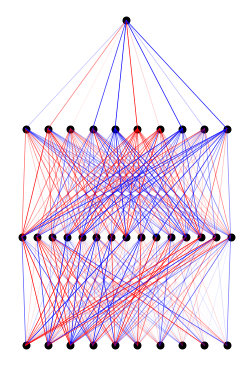

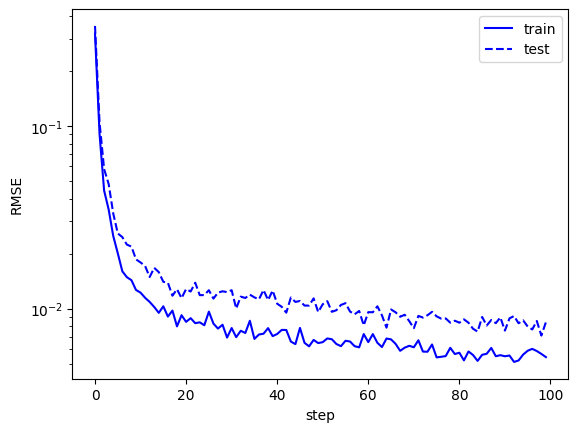

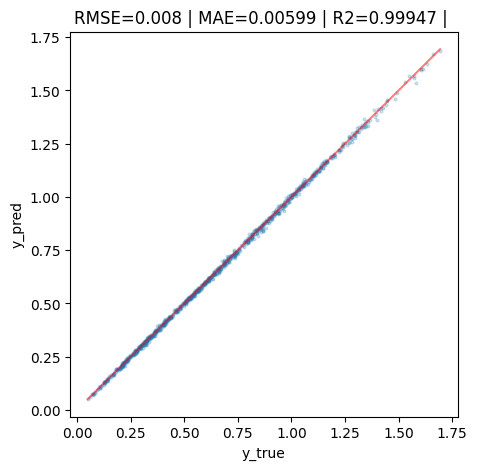

In [3]:
# initialize MLP
model = MLP(width=[n_var,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_4$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 660


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 2.53e-03 | test_loss: 2.47e-03 | reg: 6.07e+00 | : 100%|█| 100/100 [00:27<00:00,  3.70


saving model version 0.1


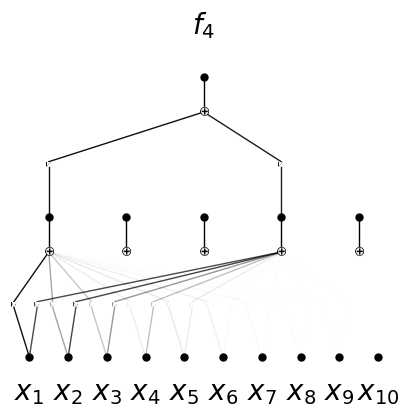

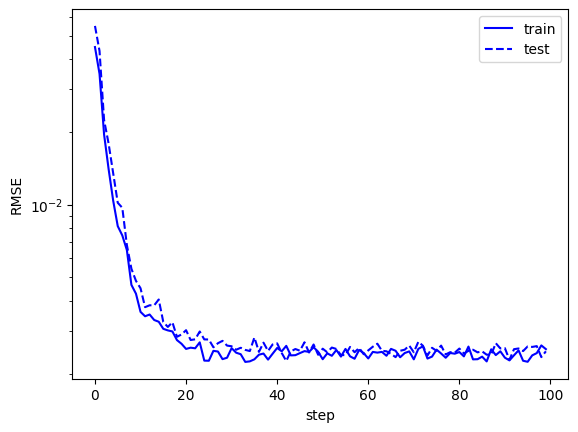

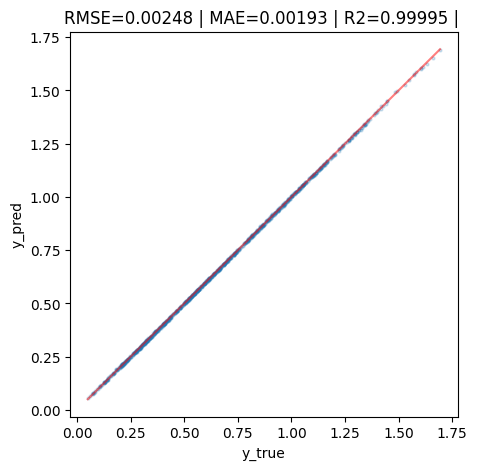

In [6]:
# initialize KAN with G=3
model = KAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results, in_vars=[f'$x_{{{i+1}}}$' for i in range(10)], out_vars = ['$f_4$'])

-----
### $\lambda$-KAN on $f_4$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 310


| train_loss: 2.52e-03 | test_loss: 2.73e-03 | reg: 4.71e+00 | : 100%|█| 150/150 [00:44<00:00,  3.34


saving model version 0.1


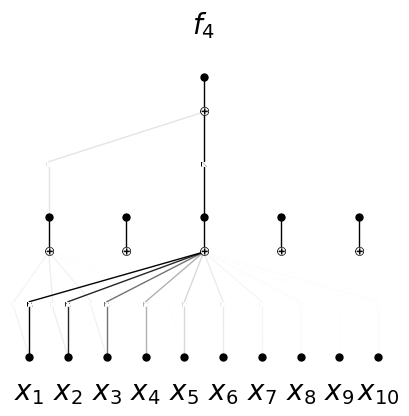

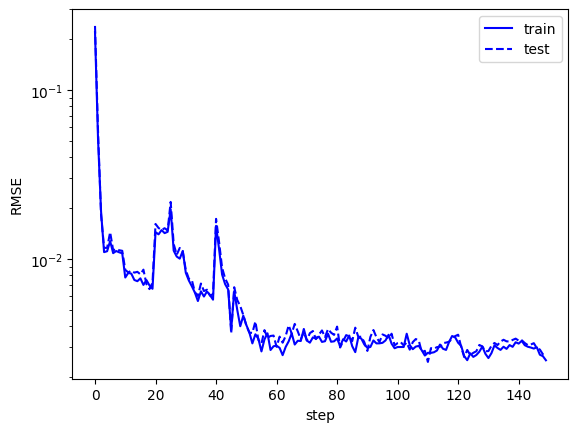

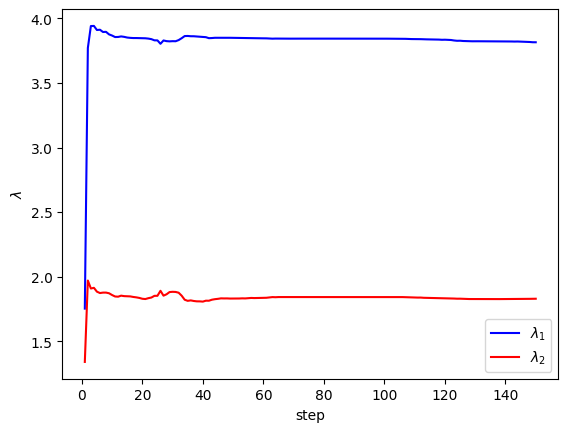

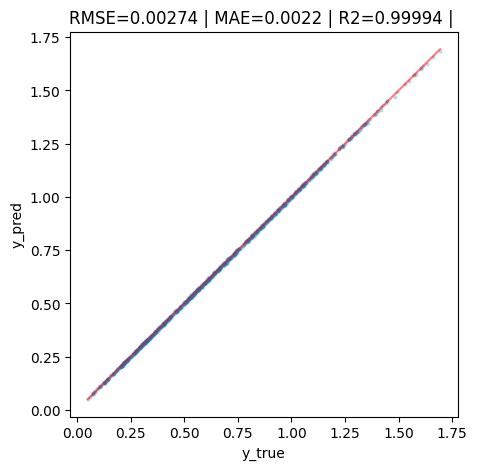

model.act_fun[0].lmd=Parameter containing:
tensor([3.8153, 1.8293, 0.9030, 0.4644, 0.2305, 0.1197, 0.0555, 0.0205, 0.0122,
        0.0171], requires_grad=True)


In [7]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars=[f'$x_{{{i+1}}}$' for i in range(10)], out_vars = ['$f_4$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [09:33,  1.73it/s]                          


module of Input importance:


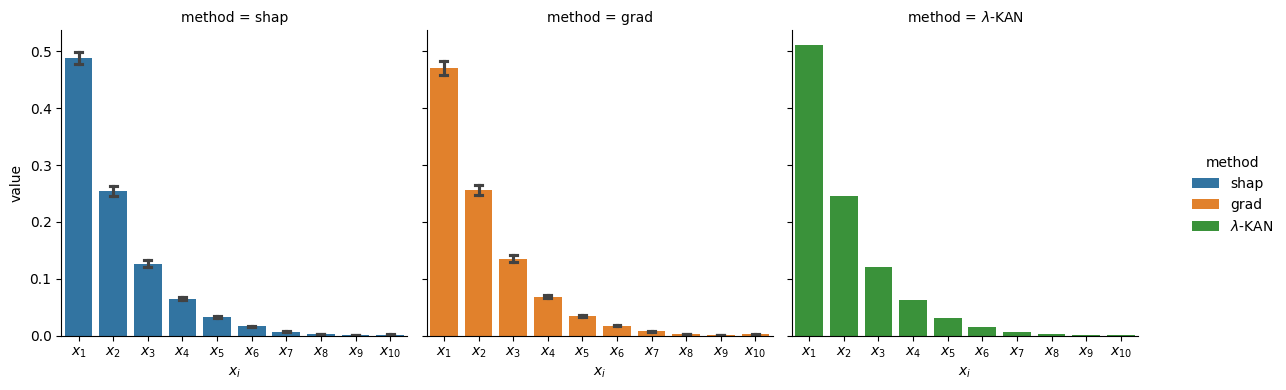

Input importance:


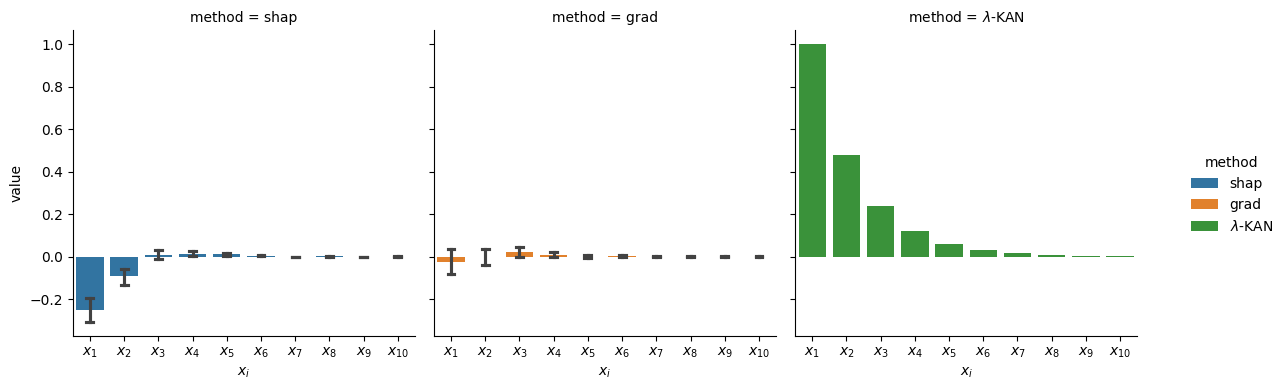

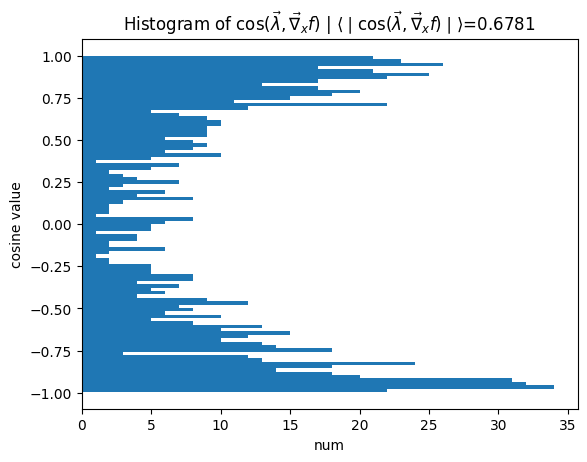

In [8]:
importance_analyse_lmdKAN(model, dataset)

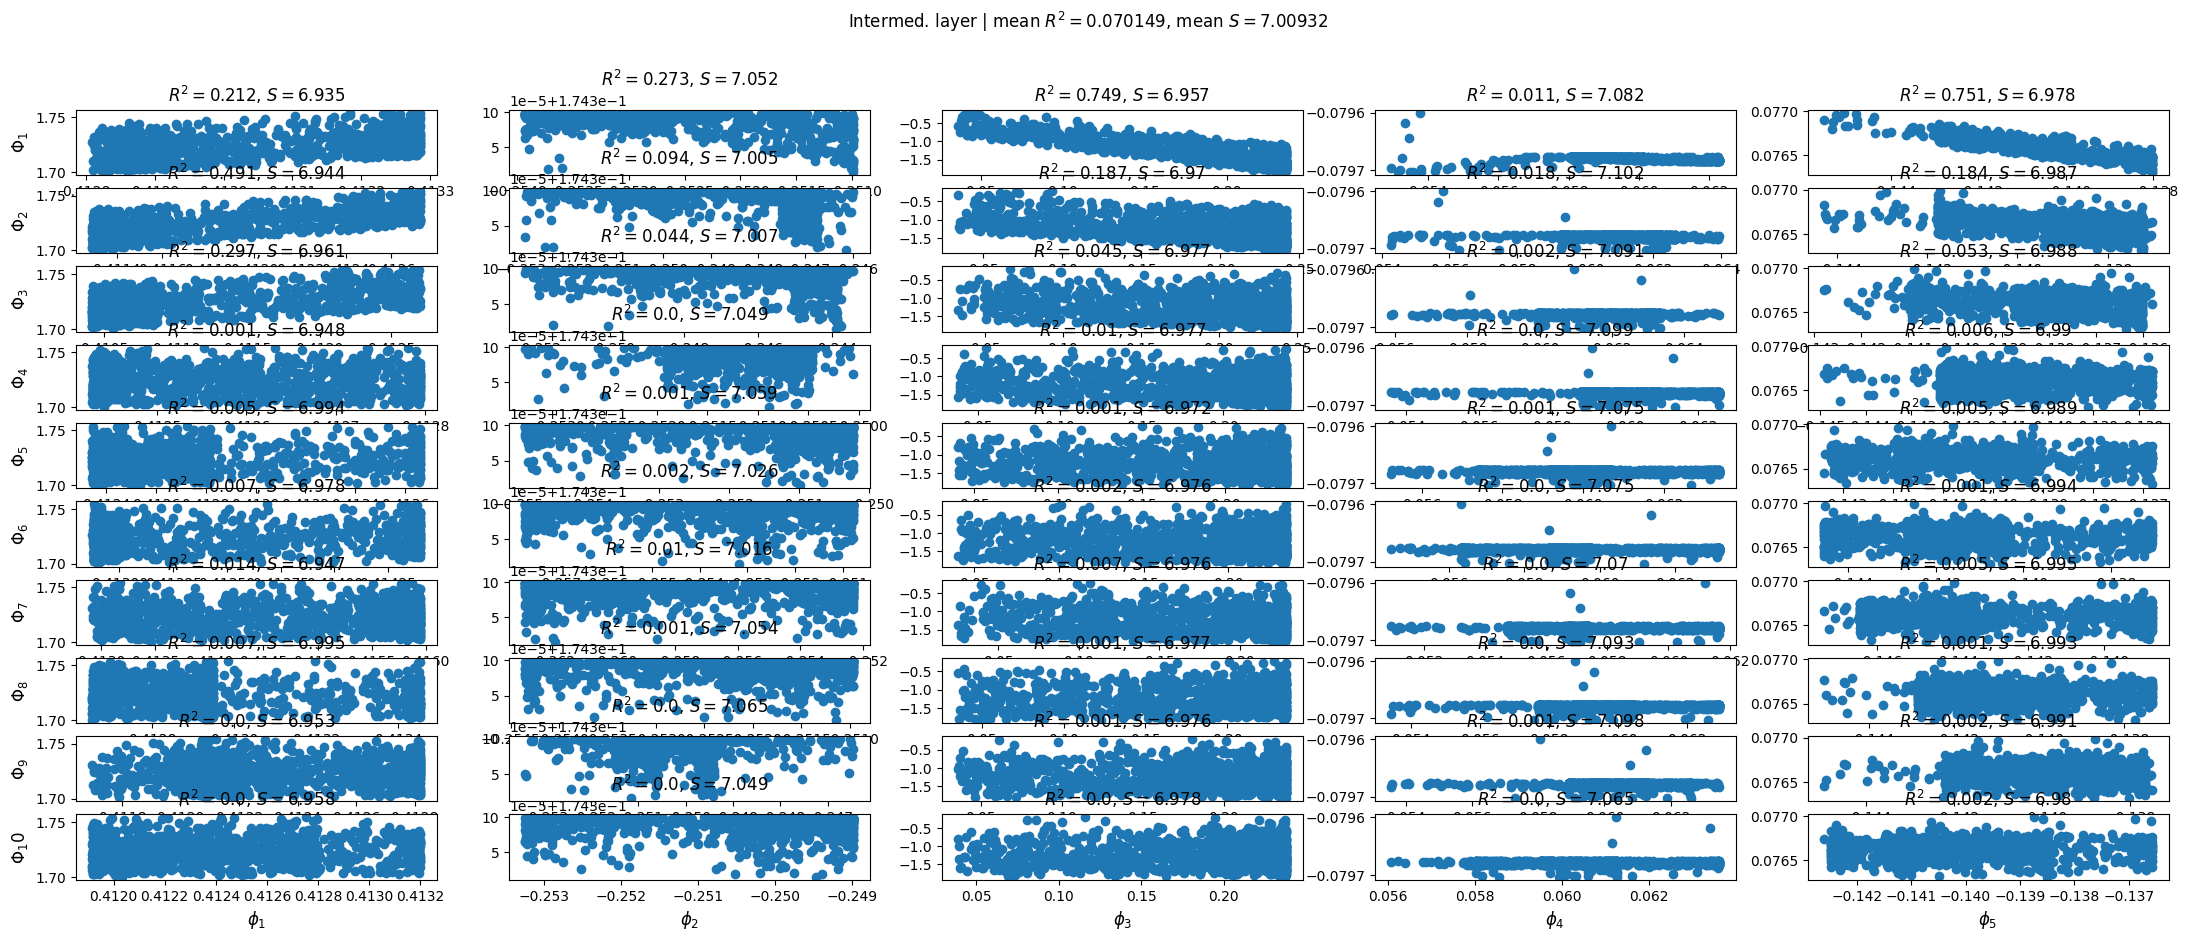

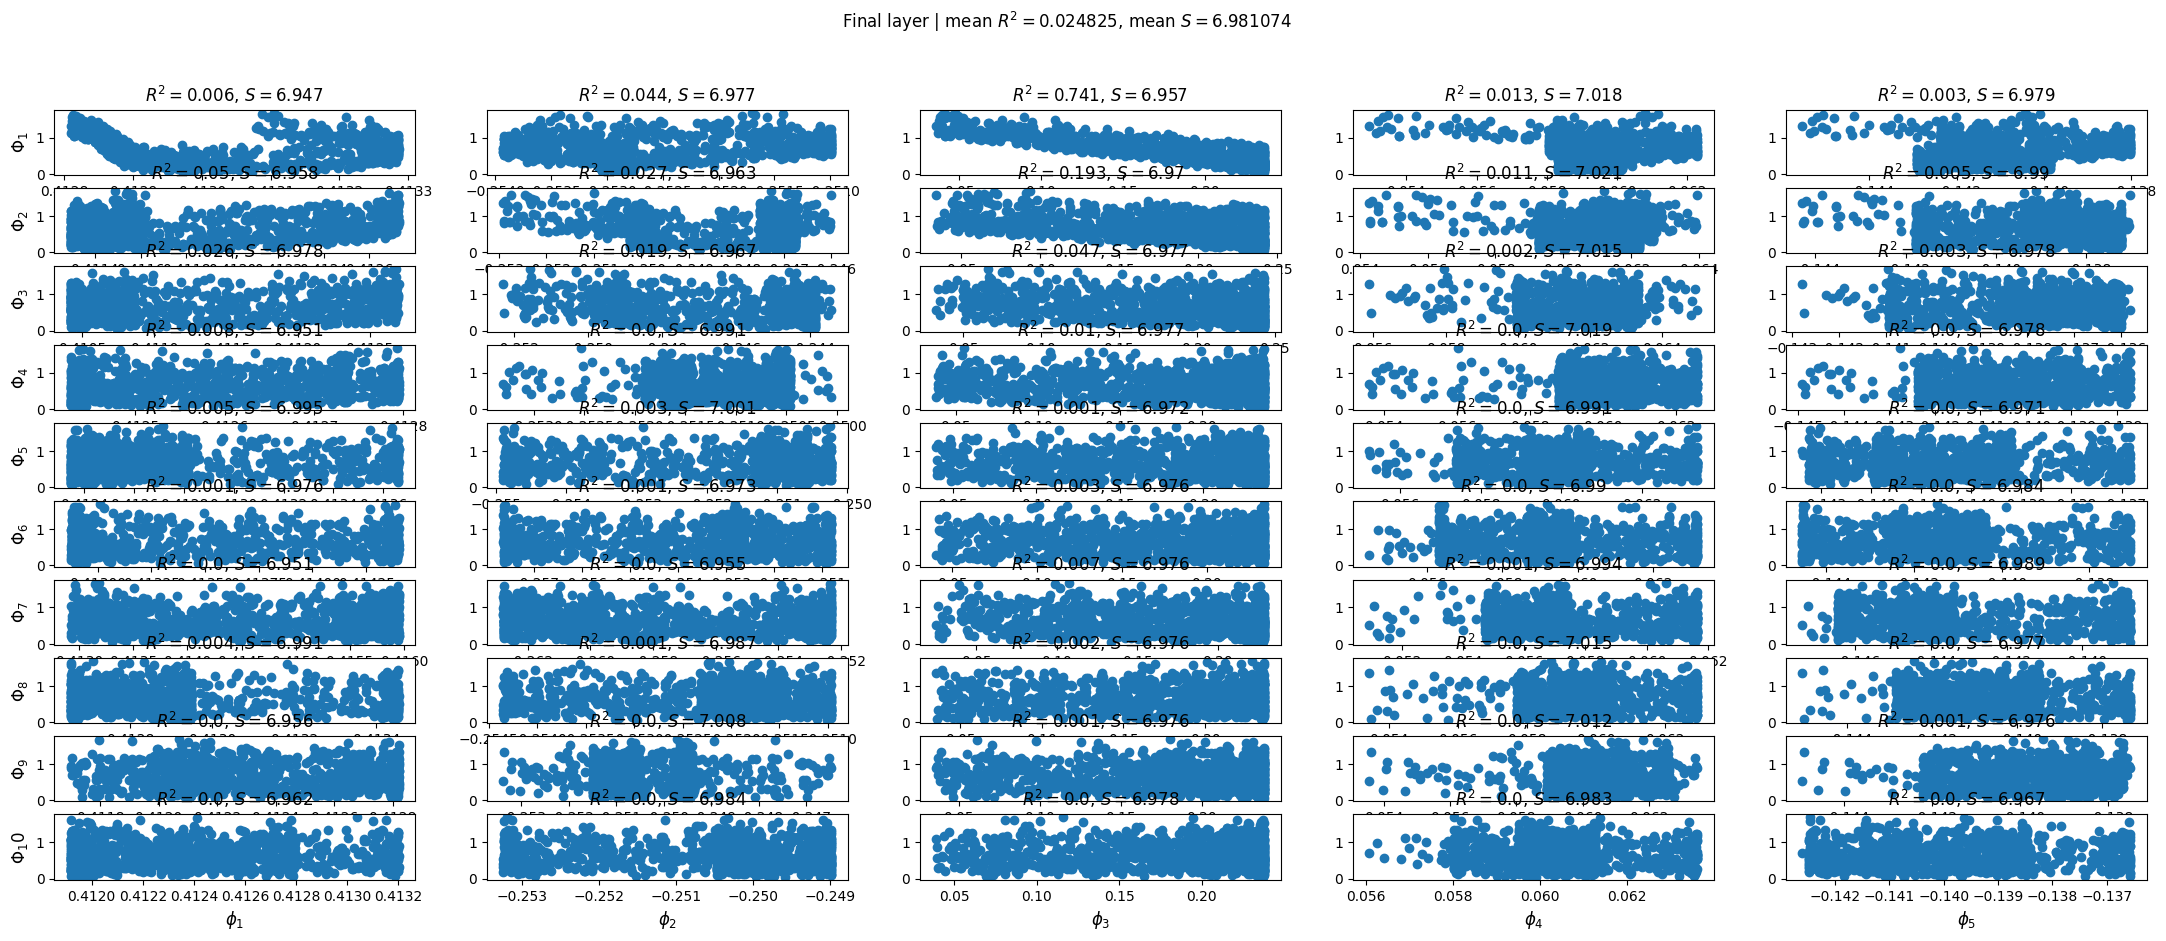

{'mean_r2': 0.02482452435961786, 'mean_matrix_entropy': 6.981074333190918}

In [9]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### trainable $\lambda$-KAN on $f_4$

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 1030


| train_loss: 3.21e-03 | test_loss: 3.68e-03 | reg: 4.92e+00 | : 100%|█| 150/150 [02:44<00:00,  1.10


saving model version 0.1


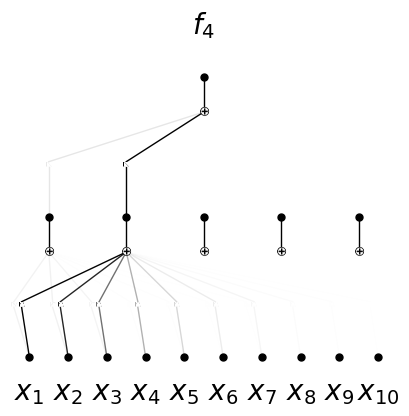

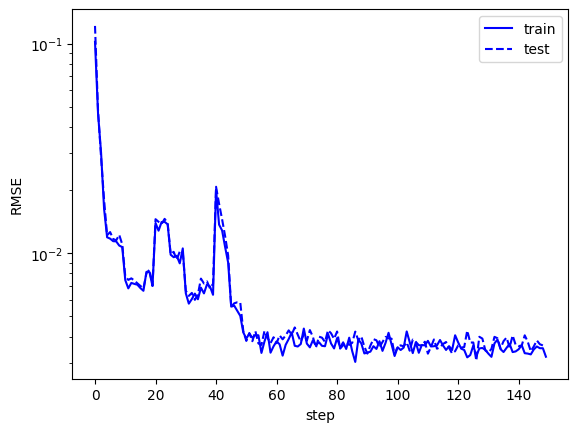

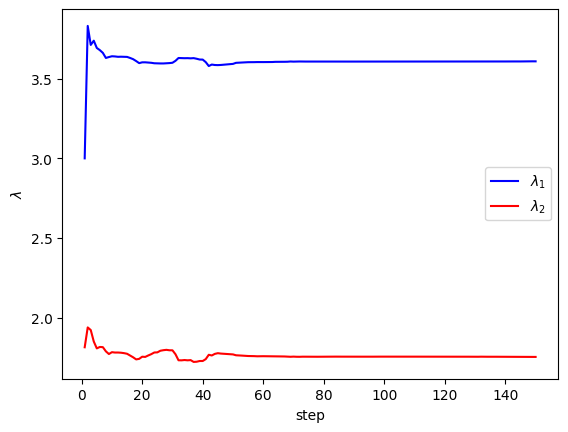

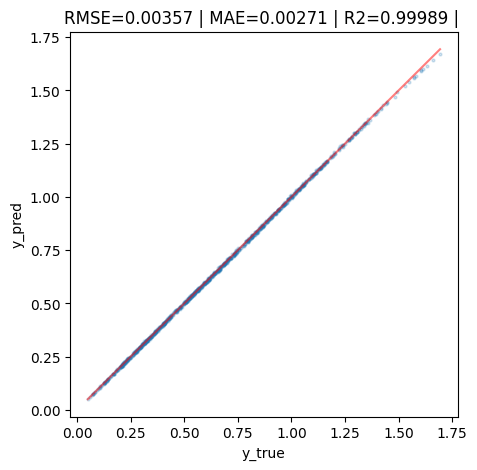

model.act_fun[0].lmd=Parameter containing:
tensor([3.6094, 1.7539, 0.8705, 0.4442, 0.2260, 0.1117, 0.0565, 0.0234, 0.0107,
        0.0043], requires_grad=True)


In [10]:
# initialize lmdKAN with G=3
model = tlmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device, tlmd_type='kan', tlmd_width=[3], tlmd_alpha=1e-1)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars=[f'$x_{{{i+1}}}$' for i in range(10)], out_vars = ['$f_4$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [19:55,  1.21s/it]                          


module of Input importance:


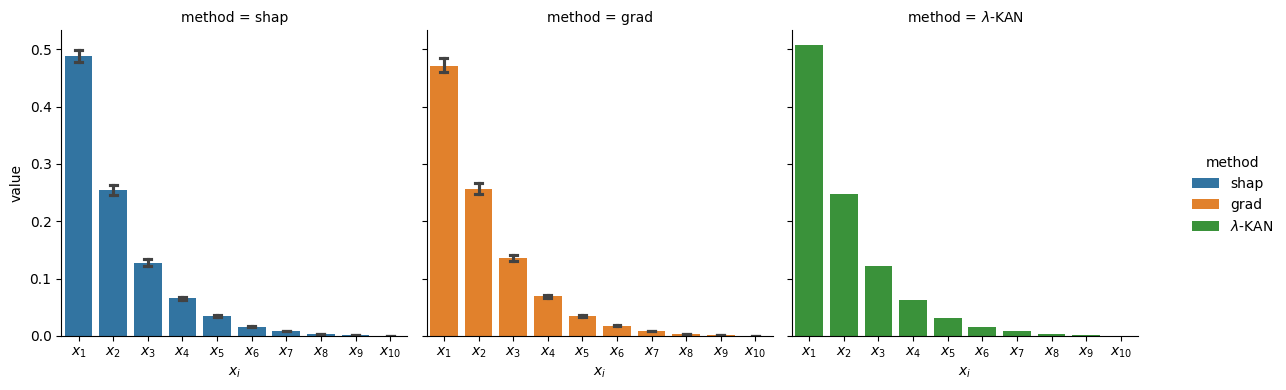

Input importance:


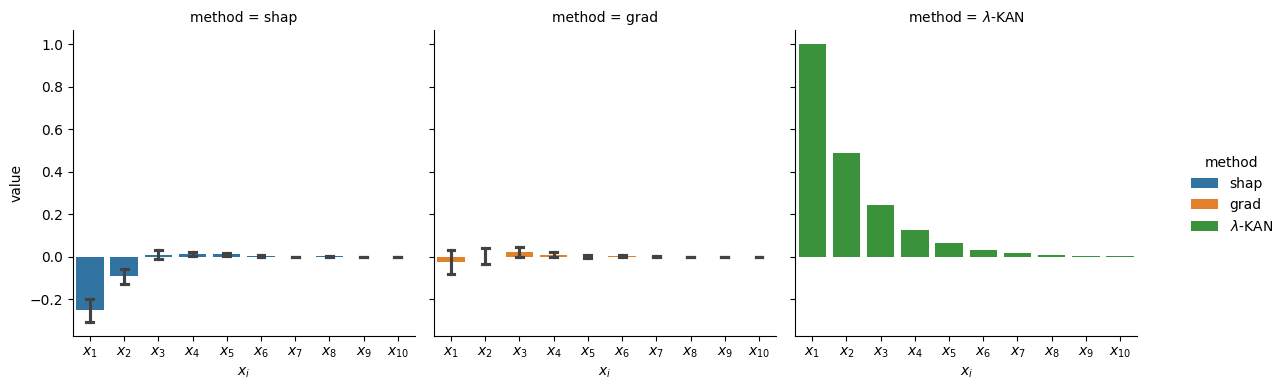

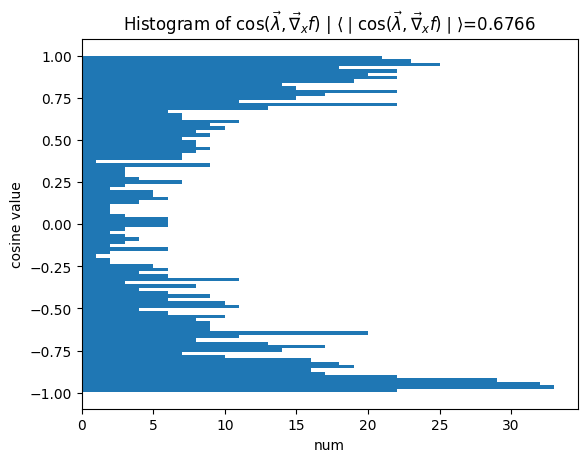

In [11]:
importance_analyse_lmdKAN(model, dataset)

ExactExplainer explainer: 1001it [21:43,  1.31s/it]                          


module of Input importance:


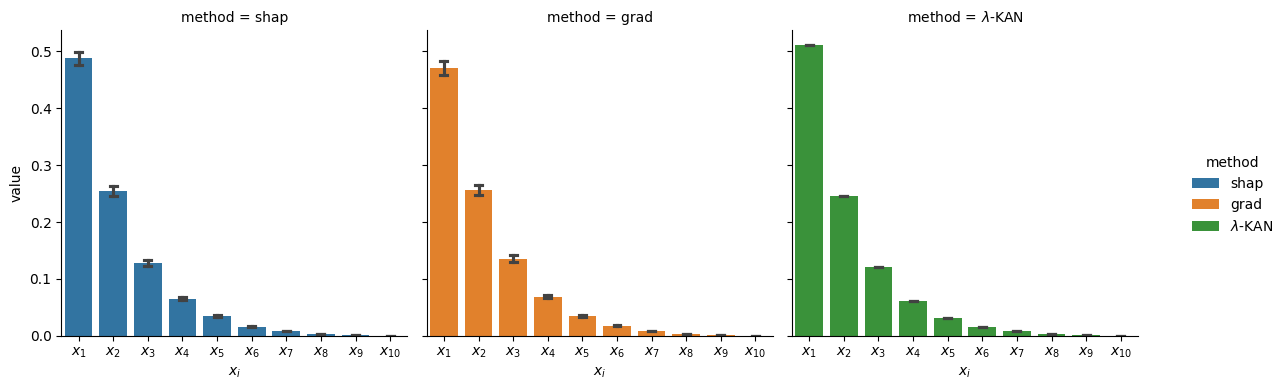

Input importance:


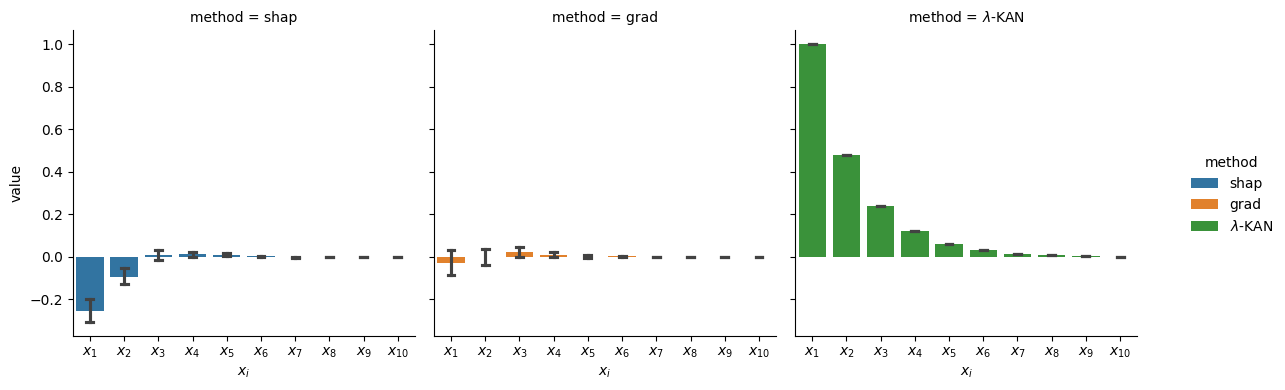

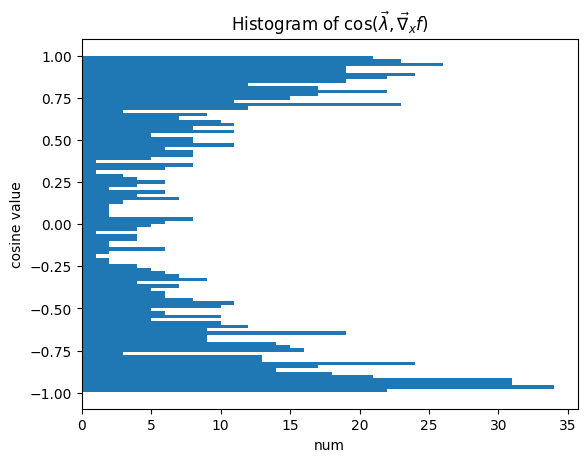

In [12]:
importance_analyse_tlmdKAN(model, dataset)

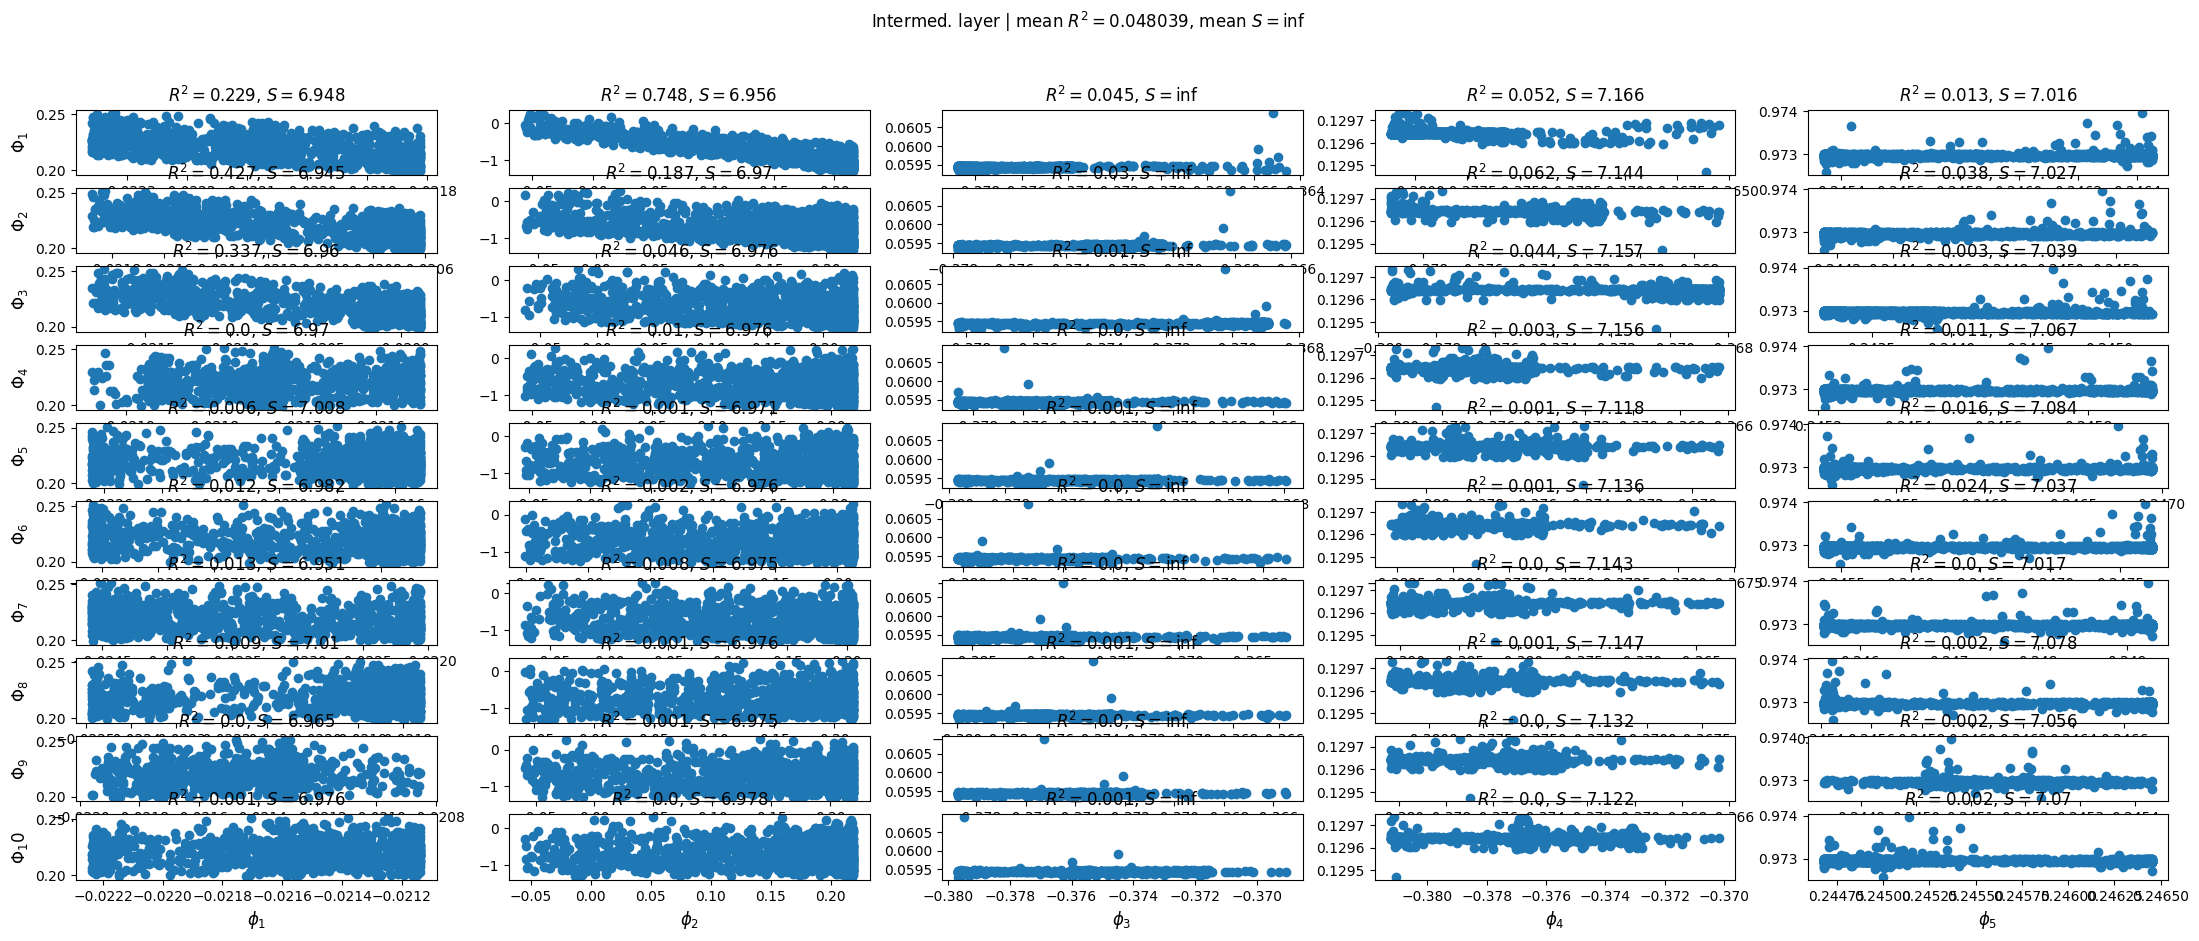

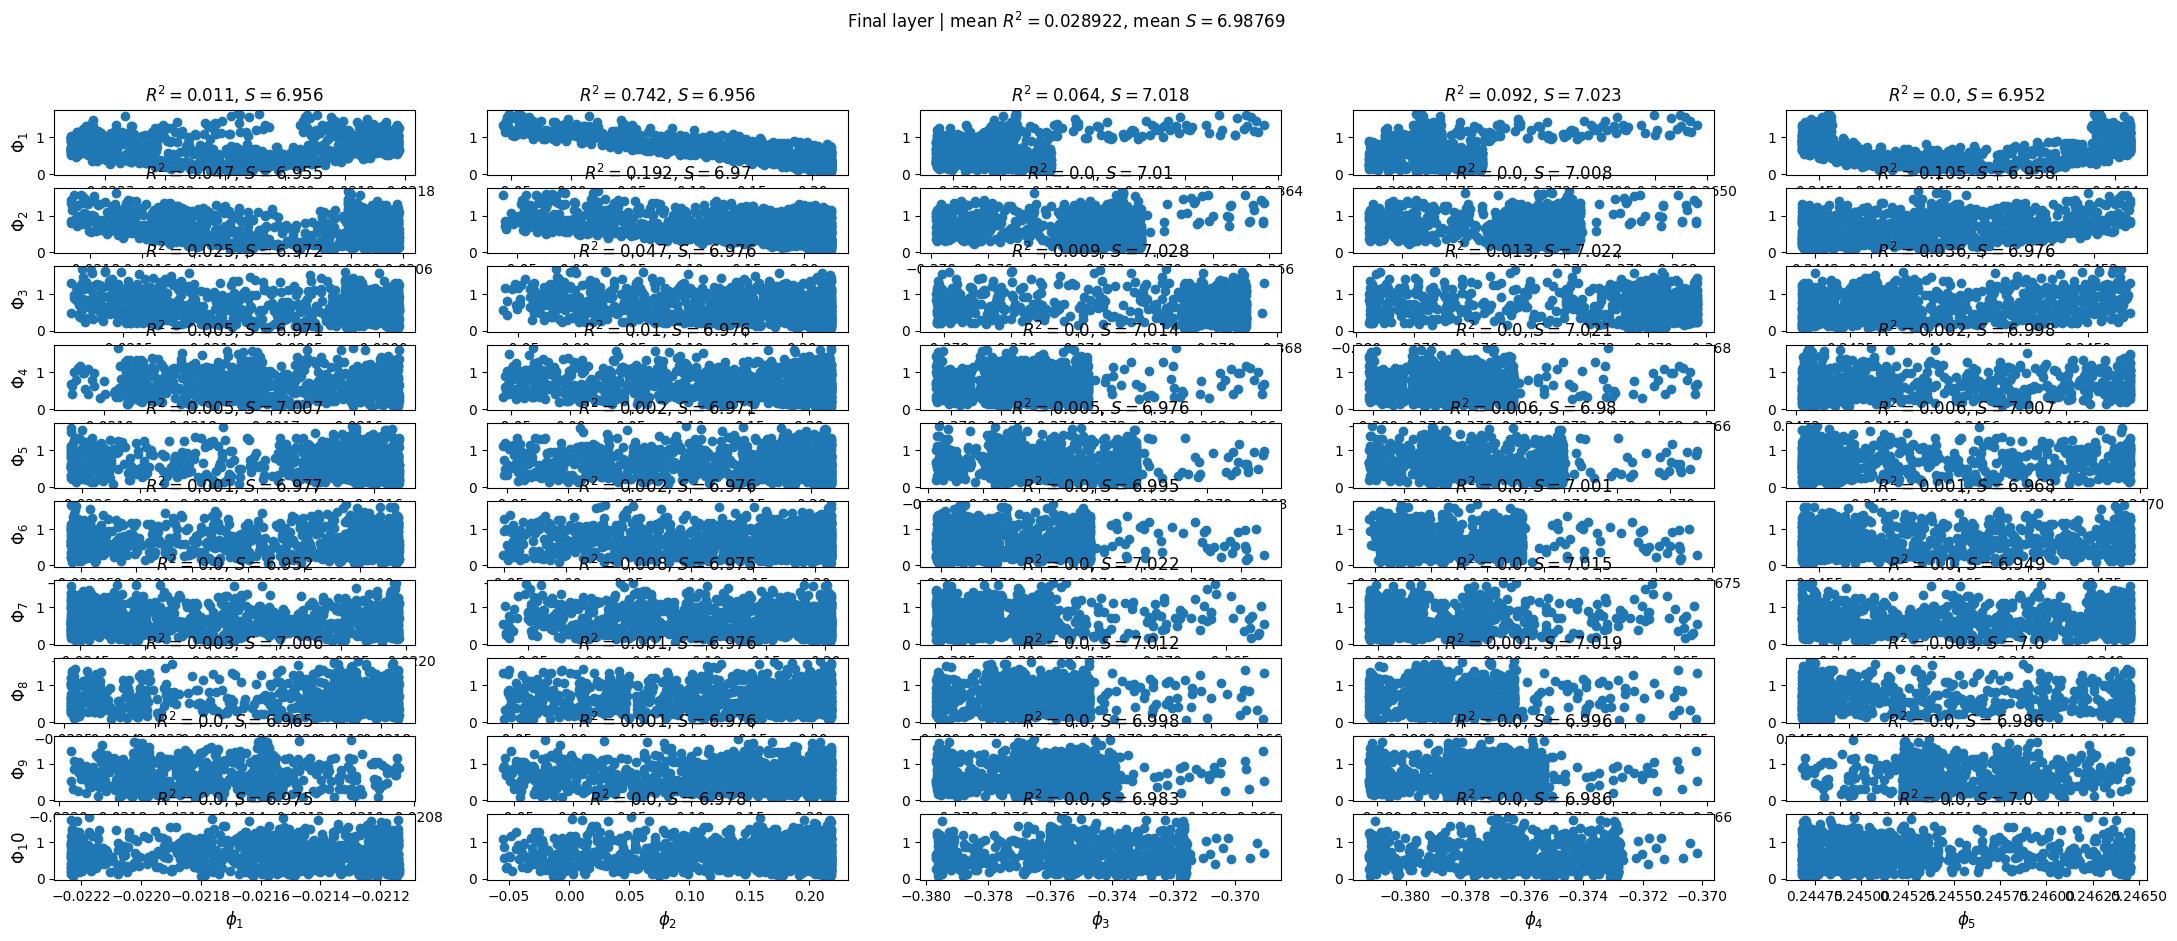

{'mean_r2': 0.02892232544972103, 'mean_matrix_entropy': 6.987690448760986}

In [13]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

## _Bellow presented code, which was not used in main experiments._

-----
-----
### $\lambda$-KAN on $f_4$ with __R2 regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 3.20e-02 | test_loss: 3.45e-02 | reg: 7.43e+00 | : 100%|█| 150/150 [02:24<00:00,  1.04


saving model version 0.1


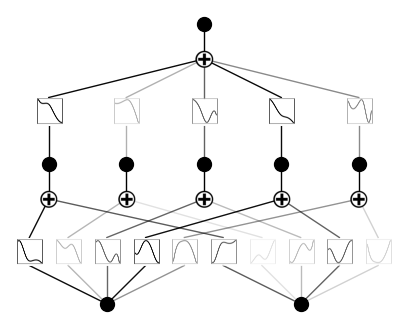

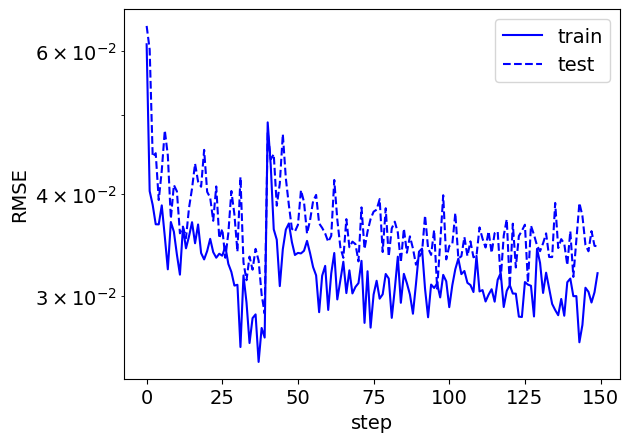

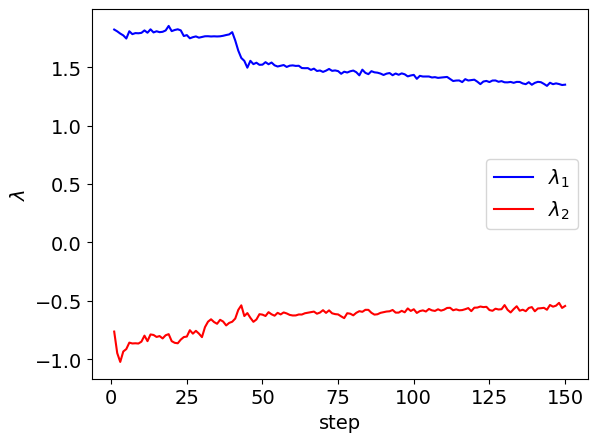

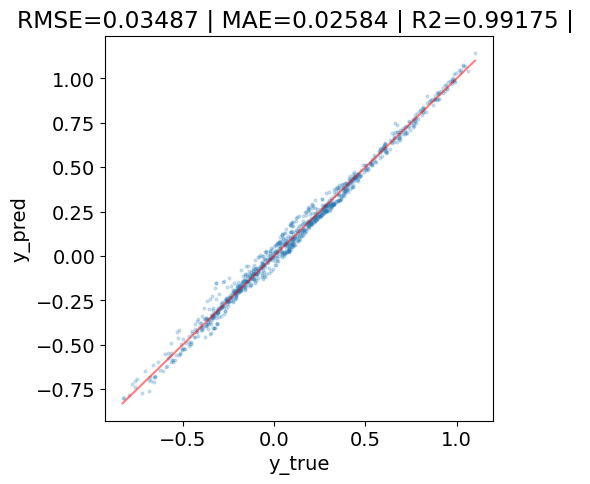

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.3509, -0.5434], requires_grad=True)


In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:28, 21.78it/s]                         


module of Input importance:


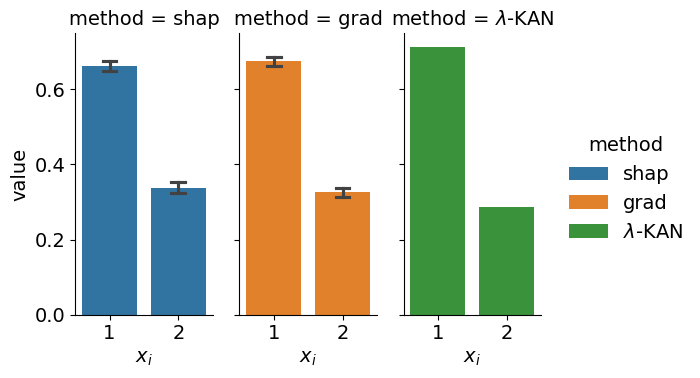

Input importance:


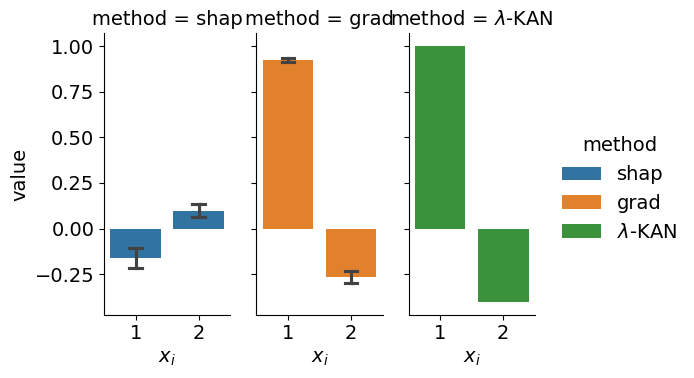

In [ ]:
importance_analyse_lmdKAN(model, dataset)

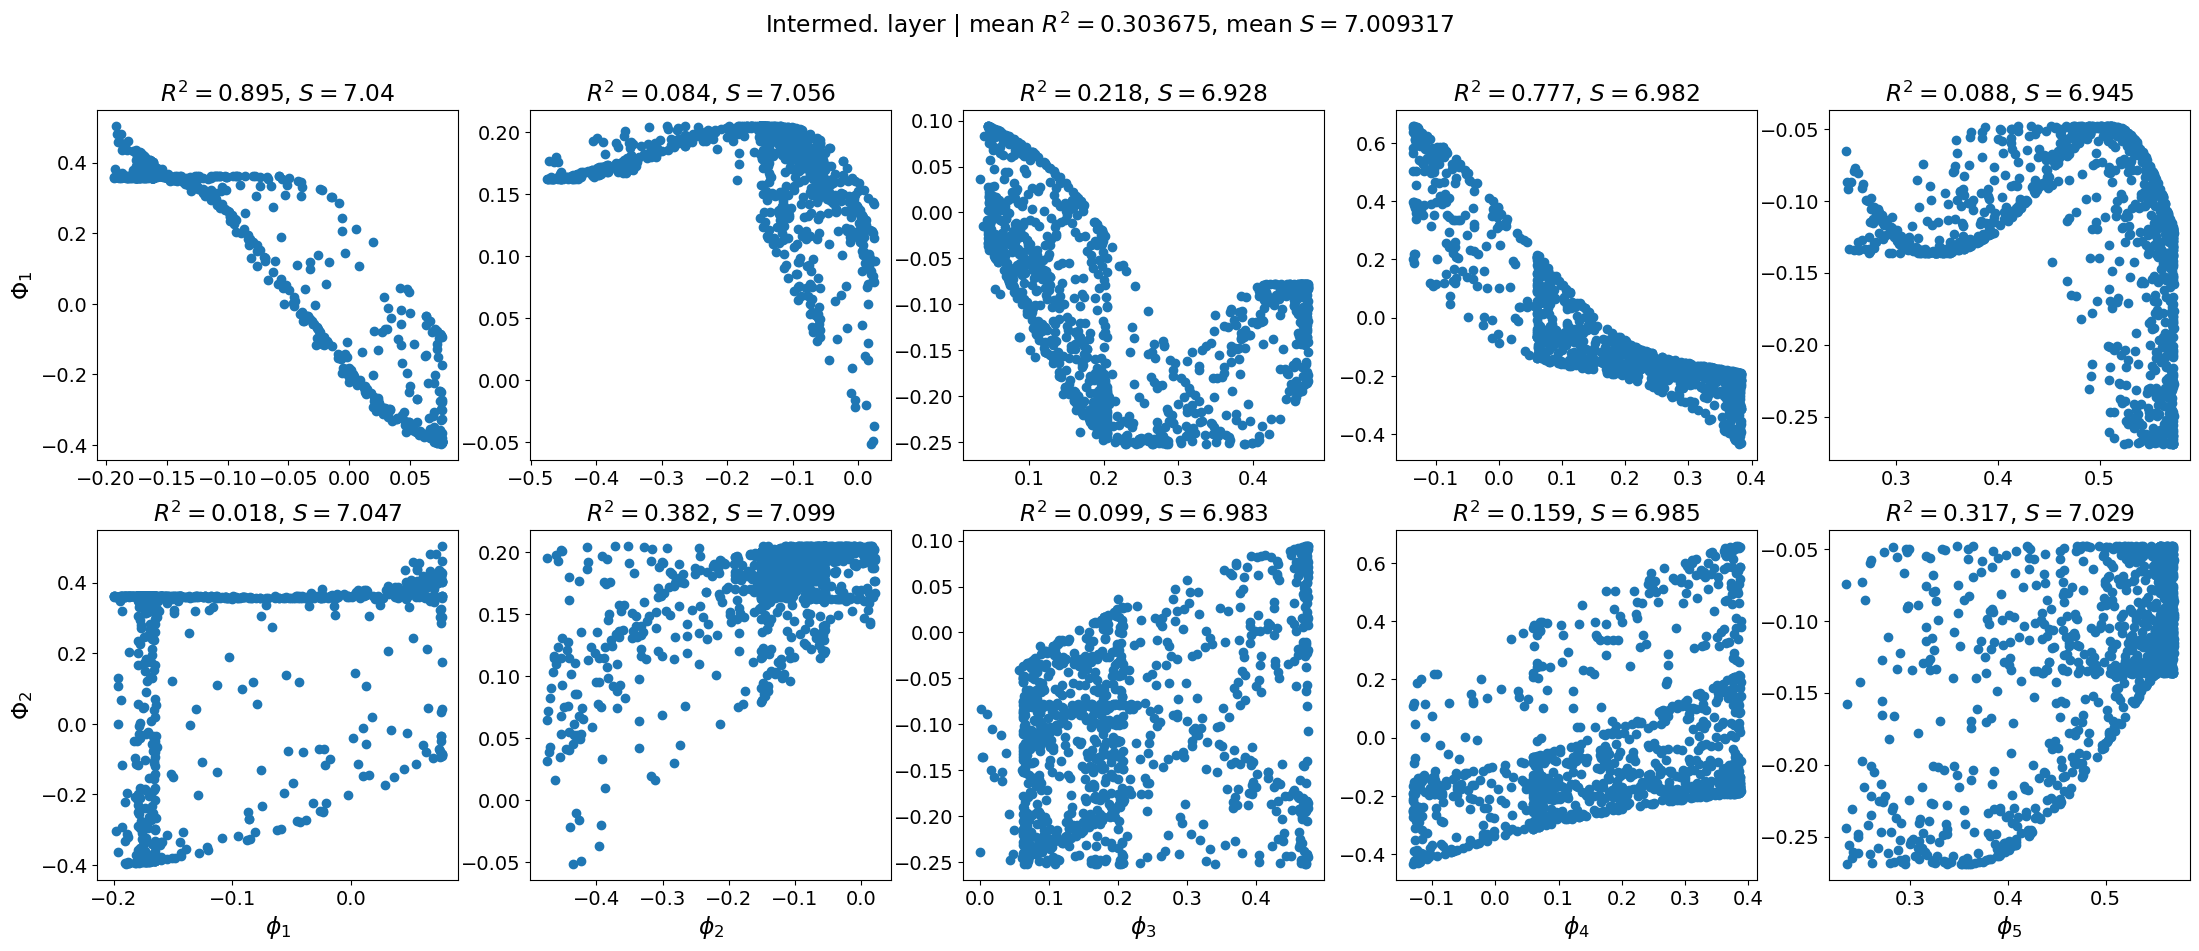

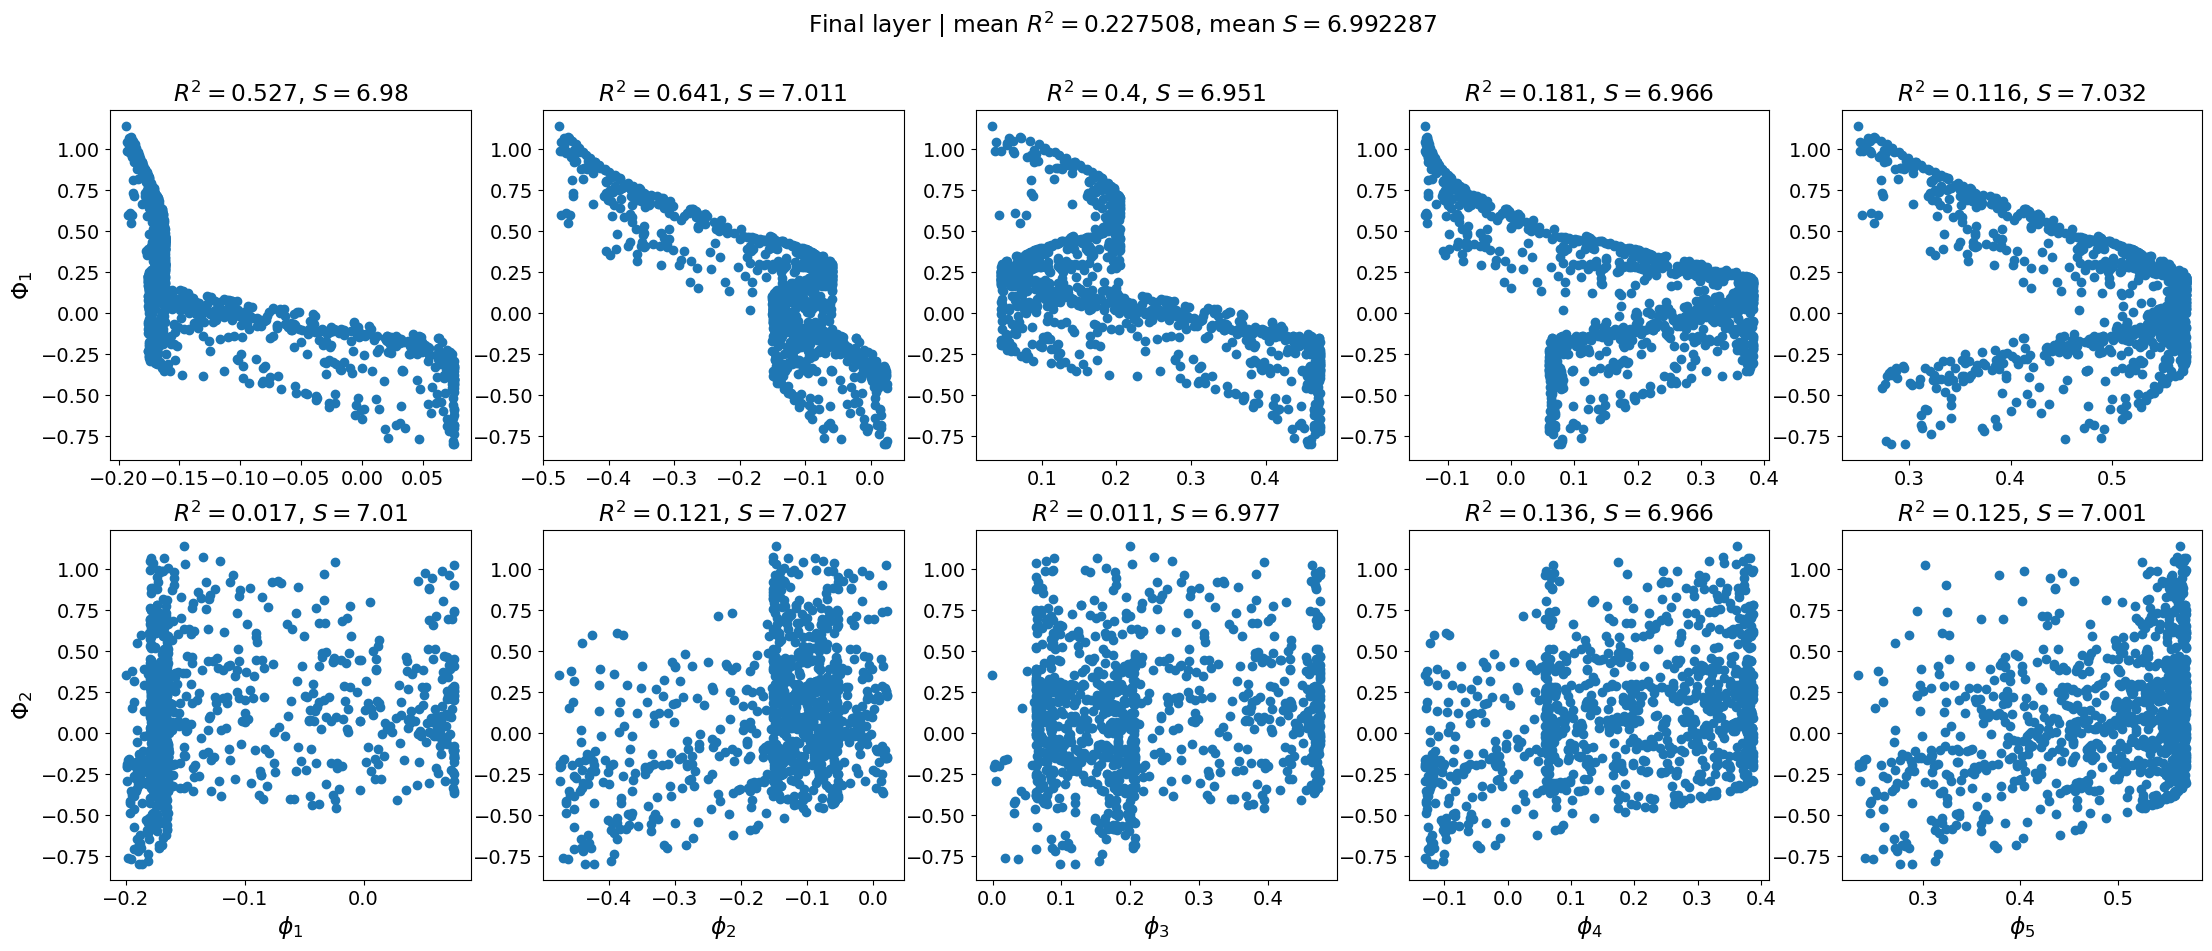

{'mean_r2': 0.22750781942158937, 'mean_matrix_entropy': 6.992286682128906}

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN on $f_4$ with __Entropy regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 3.21e-02 | test_loss: 3.32e-02 | reg: 7.67e+00 | : 100%|█| 150/150 [02:30<00:00,  1.01


saving model version 0.1


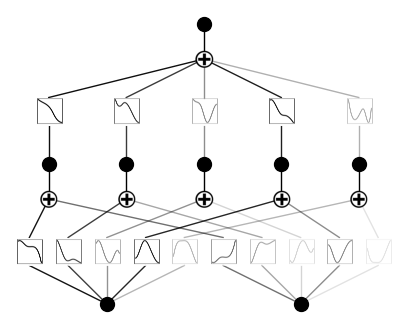

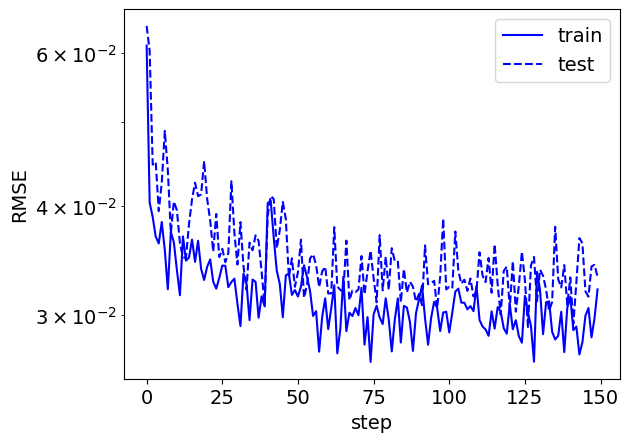

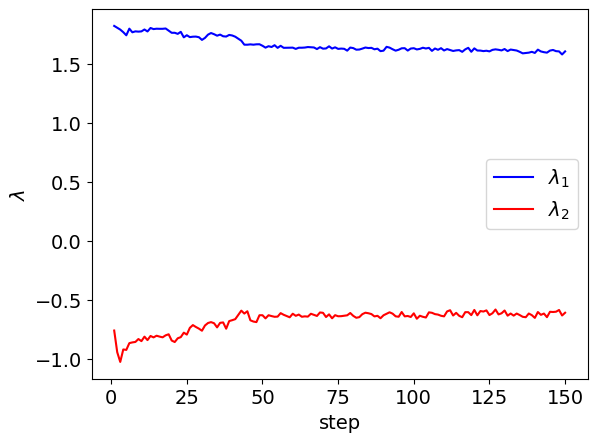

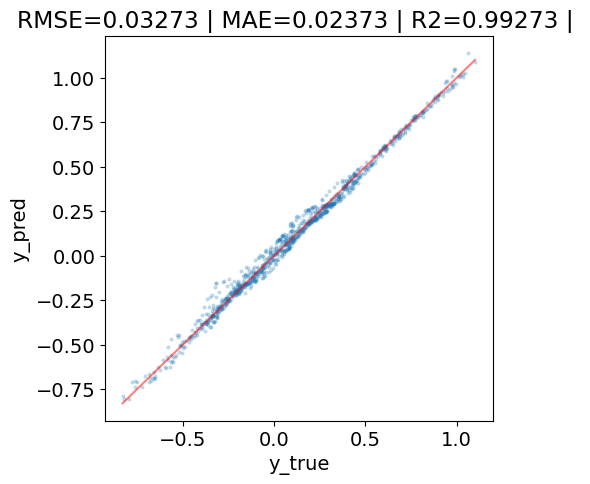

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.6066, -0.6115], requires_grad=True)


In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:20, 24.89it/s]                         


module of Input importance:


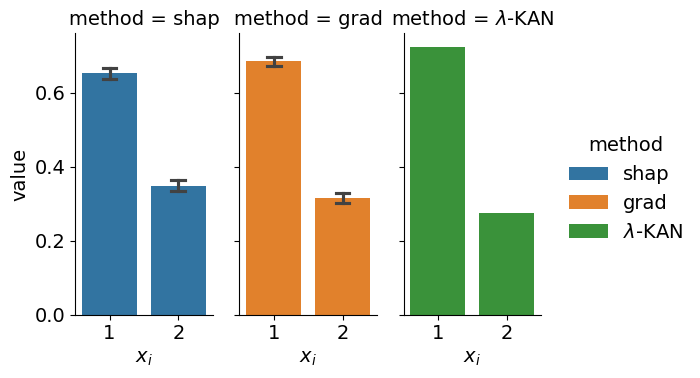

Input importance:


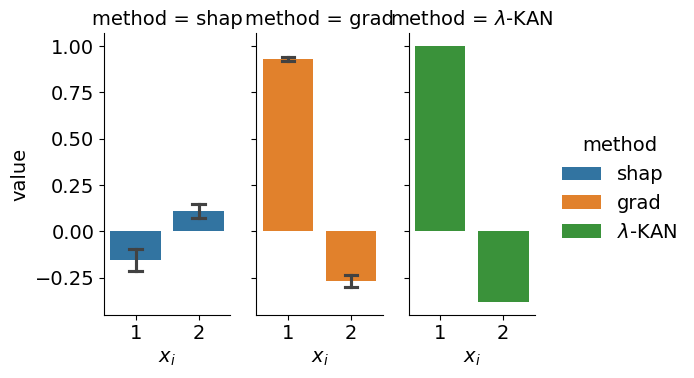

In [ ]:
importance_analyse_lmdKAN(model, dataset)

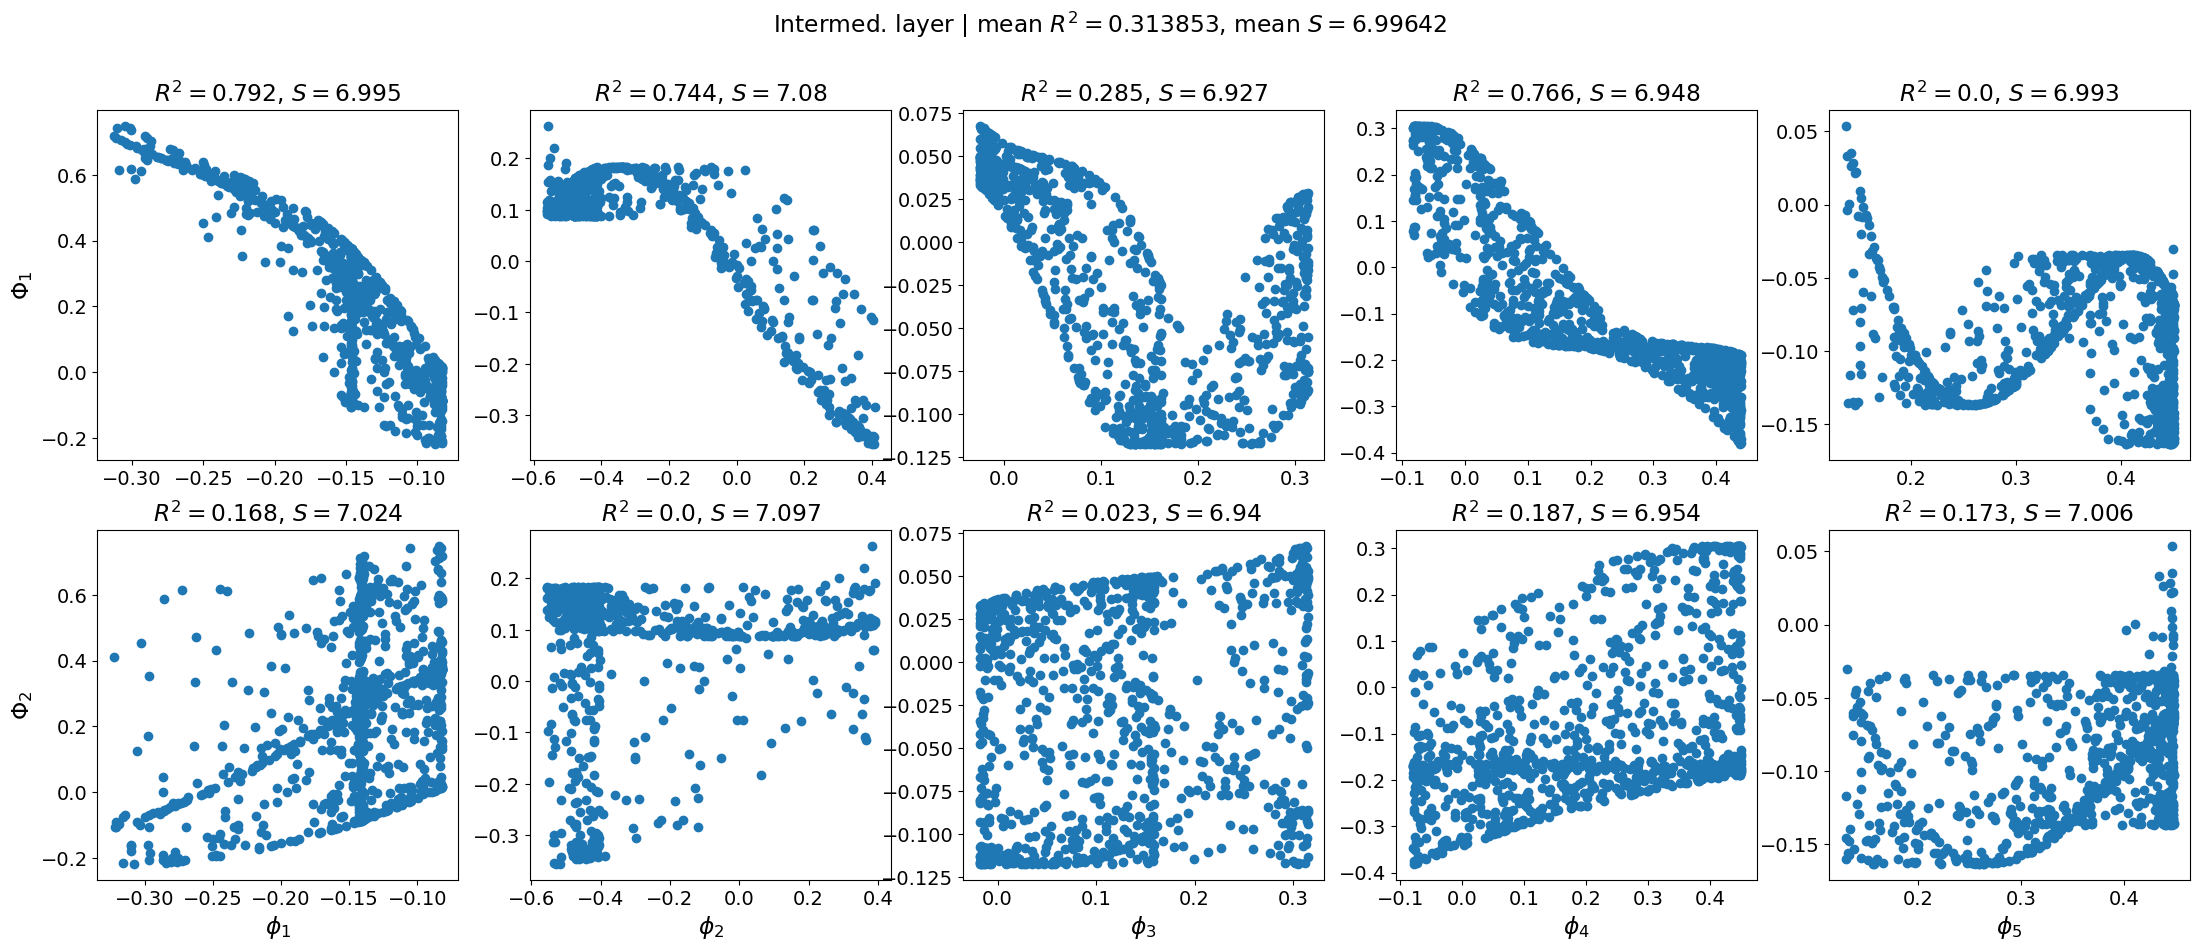

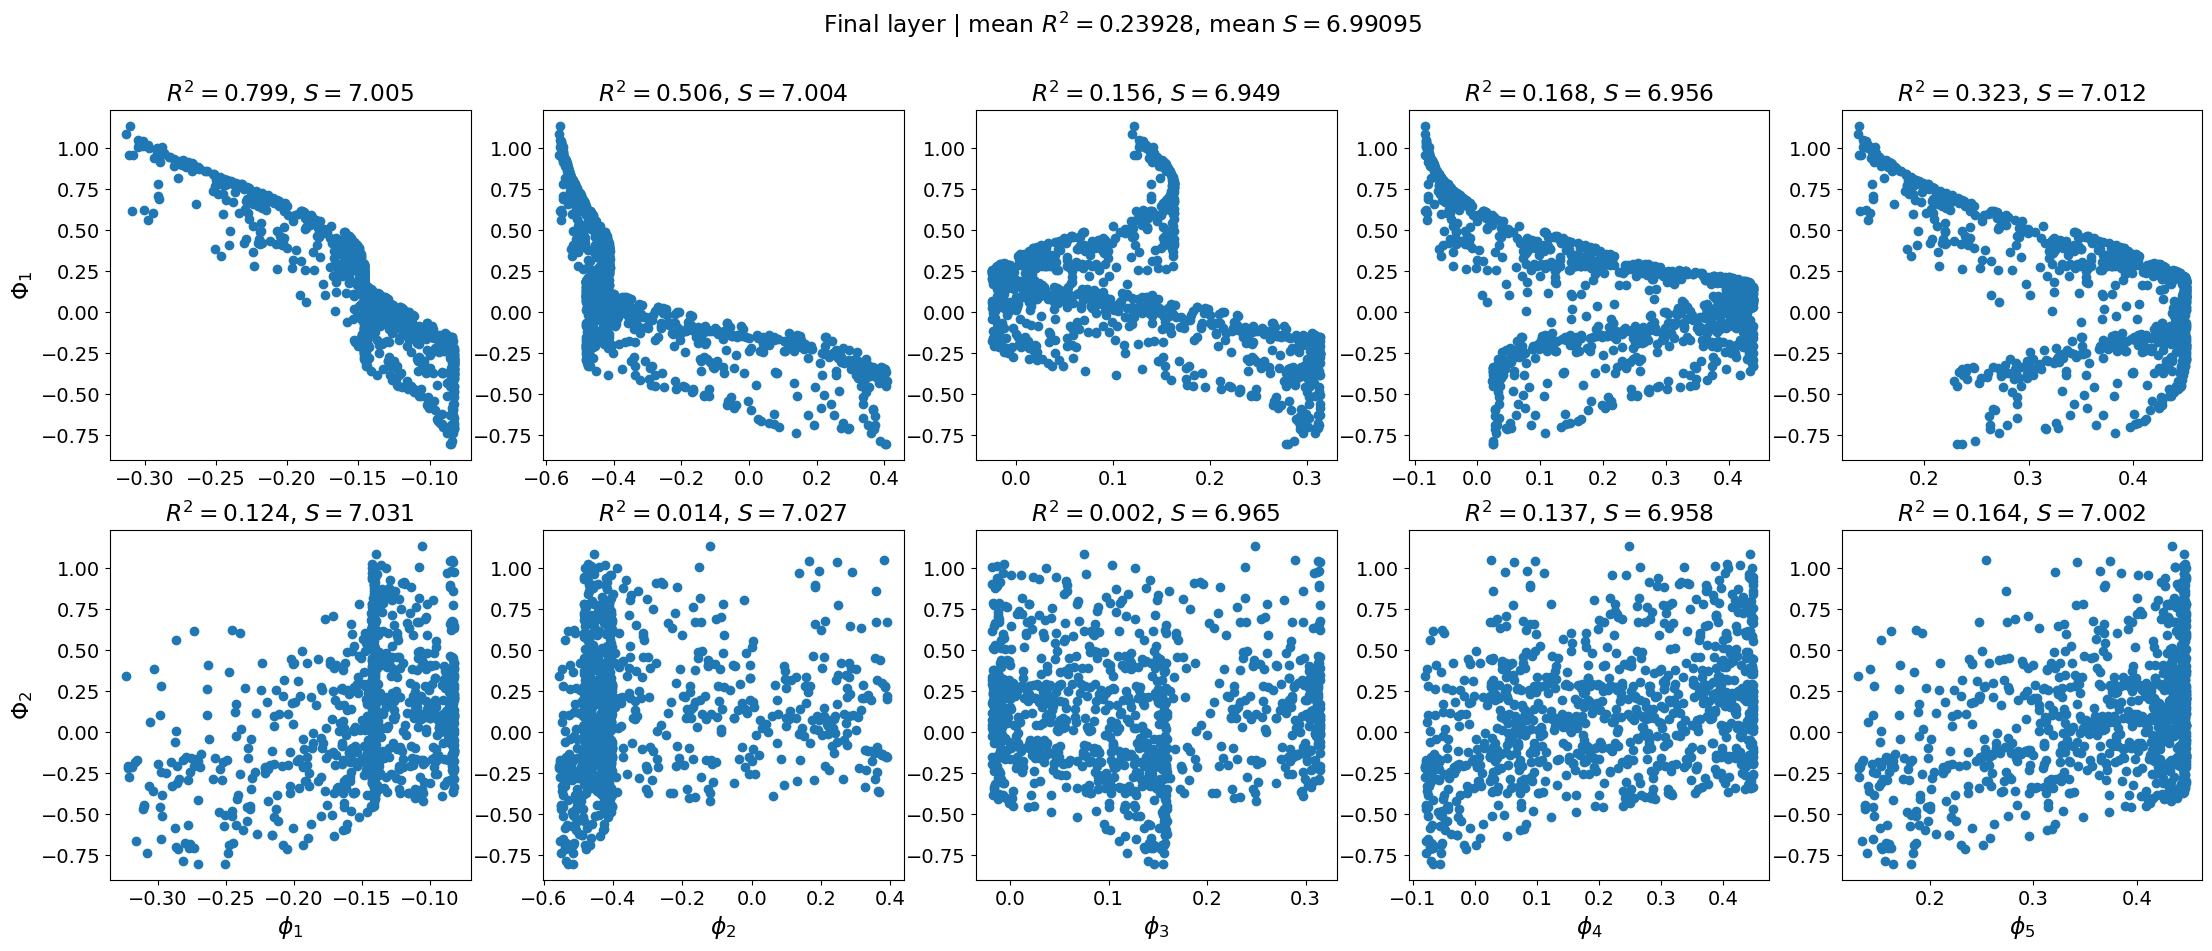

{'mean_r2': 0.23927995741833002, 'mean_matrix_entropy': 6.990950107574463}

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
-----
### $\lambda$-KAN on $f_4$ with __R2 regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


| train_loss: 3.20e-02 | test_loss: 3.41e-02 | reg: 7.28e+00 | : 100%|█| 150/150 [01:23<00:00,  1.81


saving model version 0.1


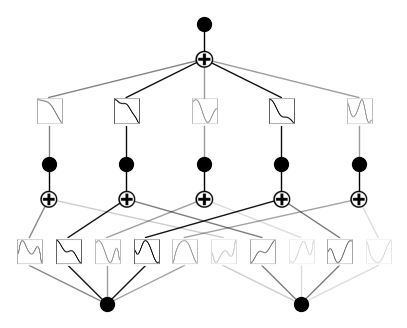

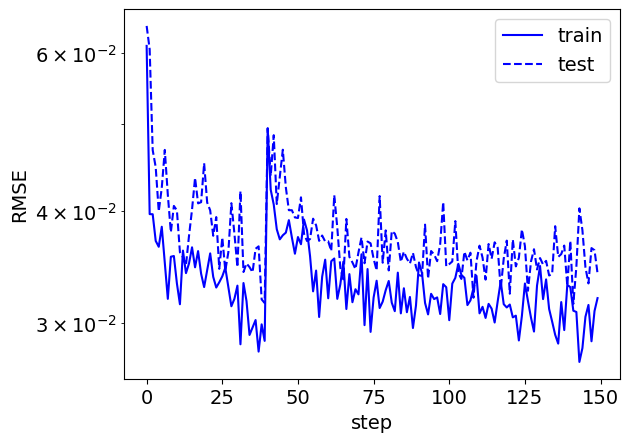

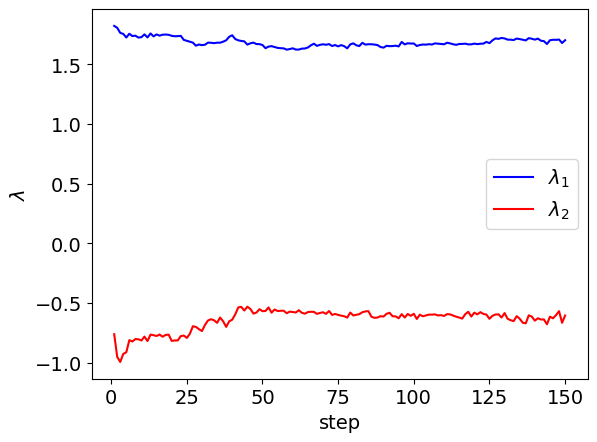

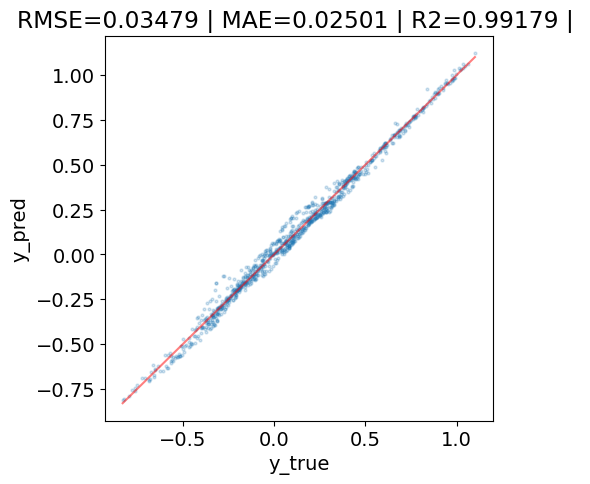

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.7028, -0.6051], requires_grad=True)


In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:14, 22.68it/s]                         


module of Input importance:


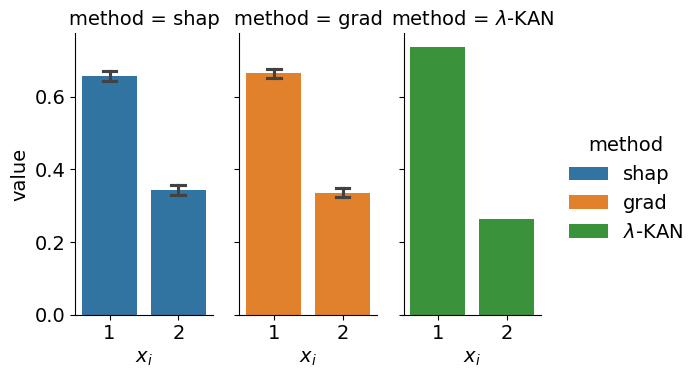

Input importance:


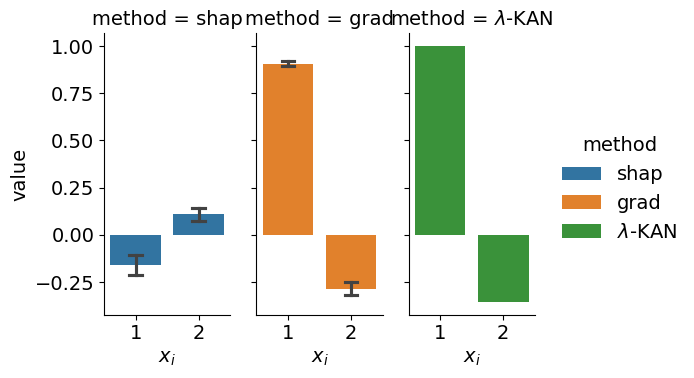

In [ ]:
importance_analyse_lmdKAN(model, dataset)

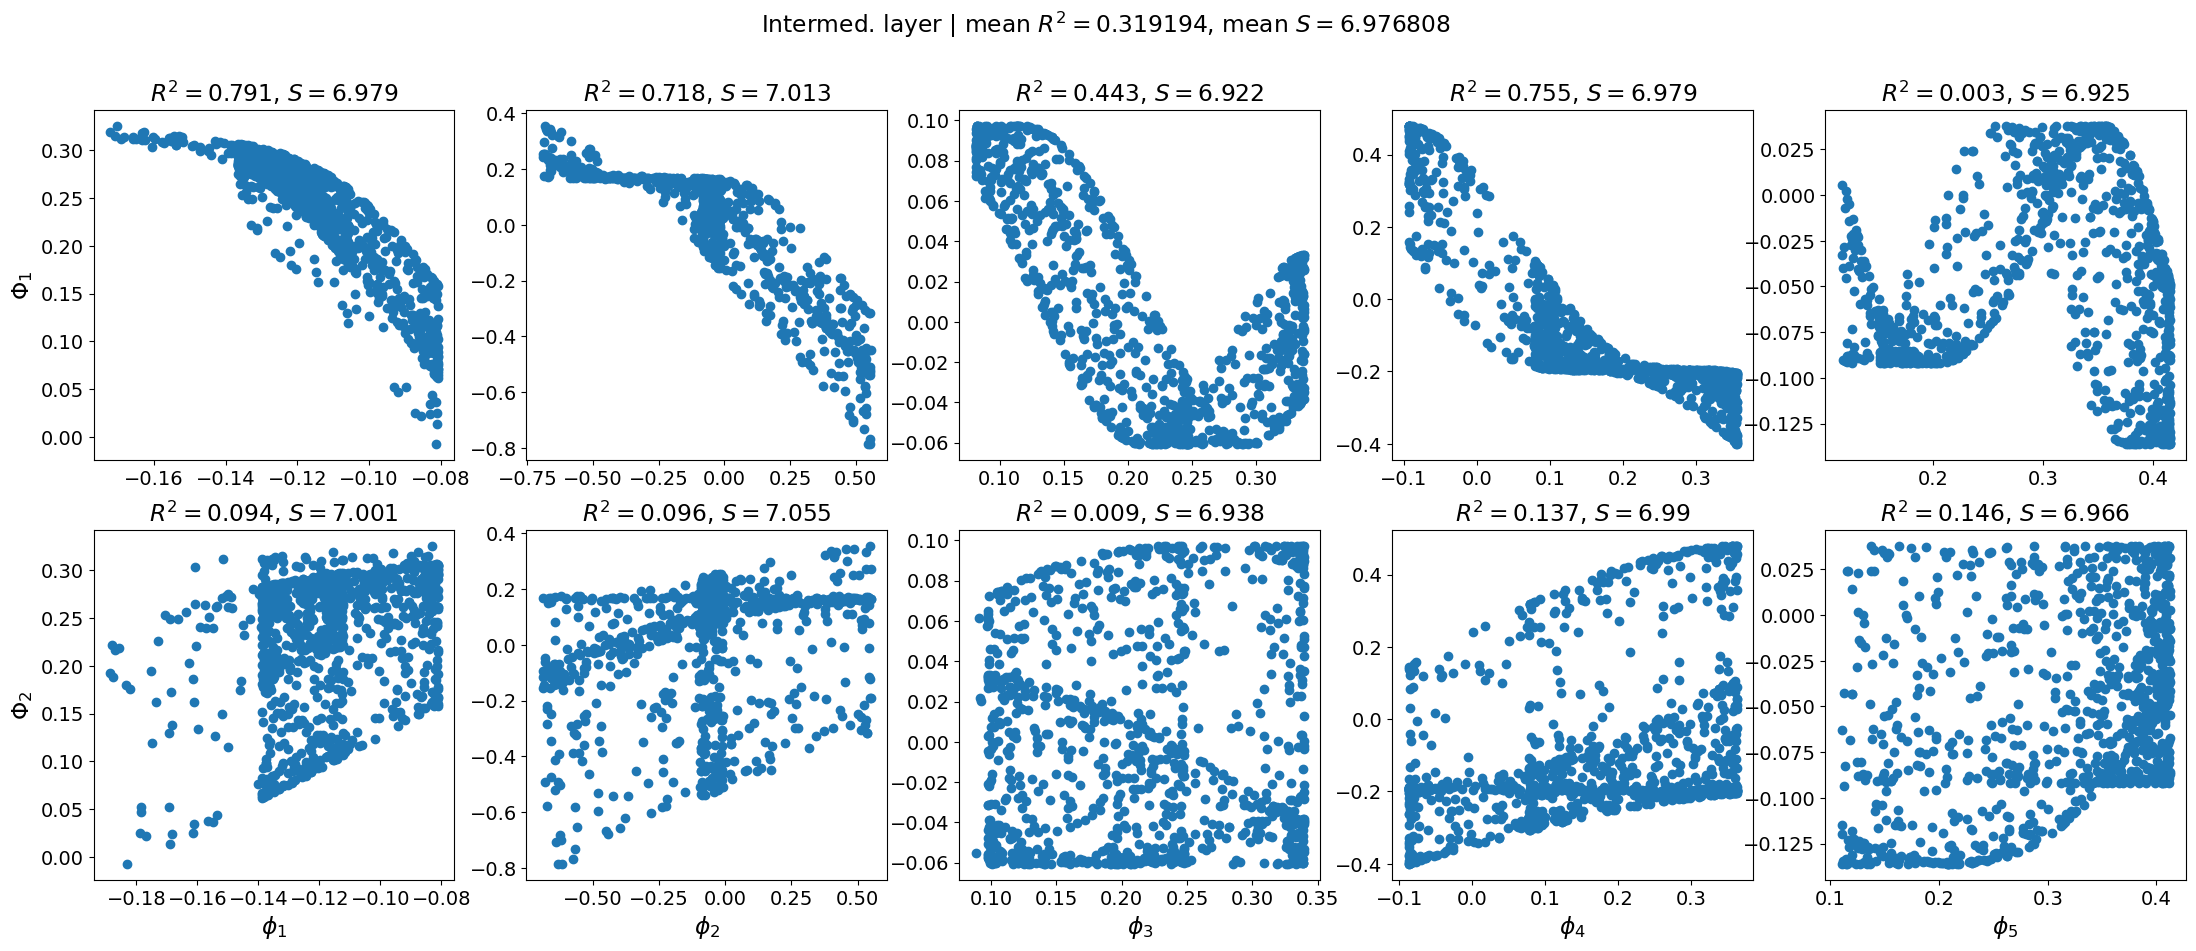

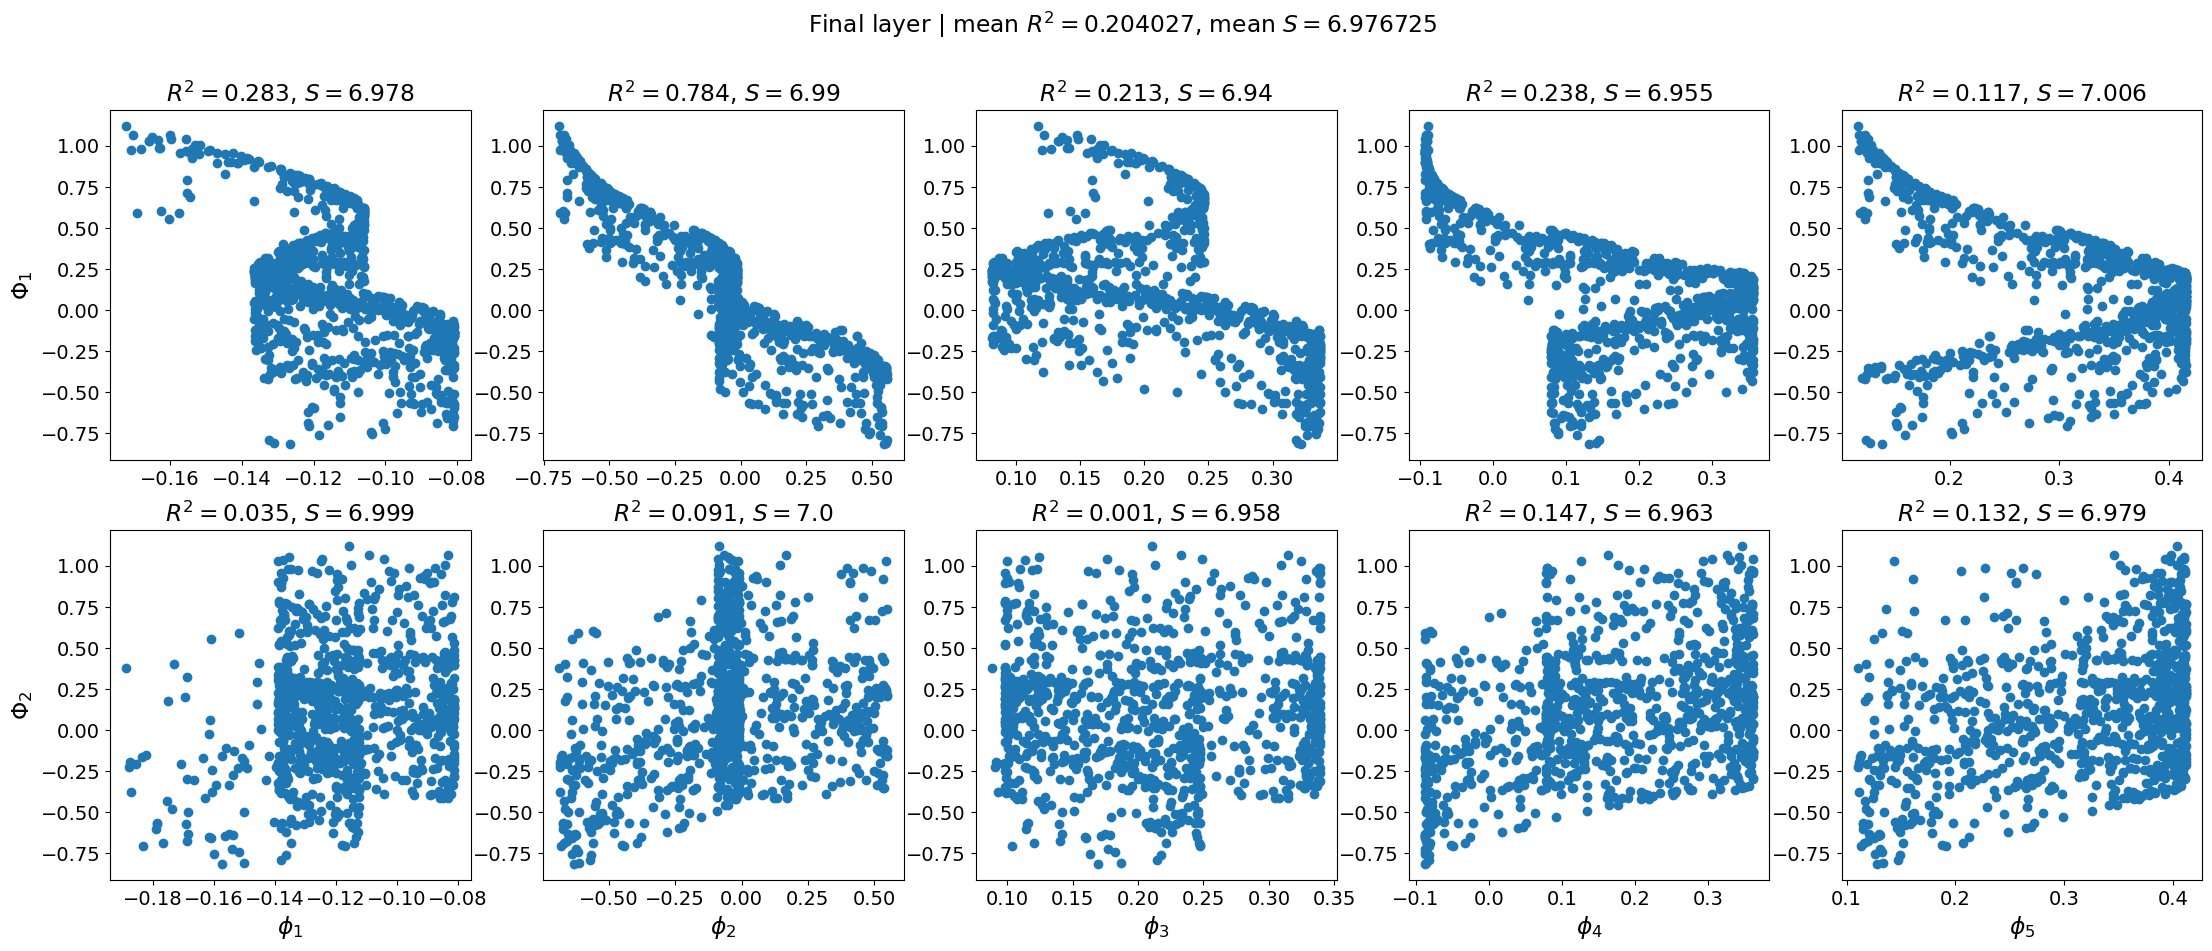

{'mean_r2': 0.20402672272757627, 'mean_matrix_entropy': 6.976725101470947}

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN on $f_4$ with __Entropy regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.41e-02 | test_loss: 2.62e-02 | reg: 6.76e+00 | : 100%|█| 150/150 [01:50<00:00,  1.36


saving model version 0.1


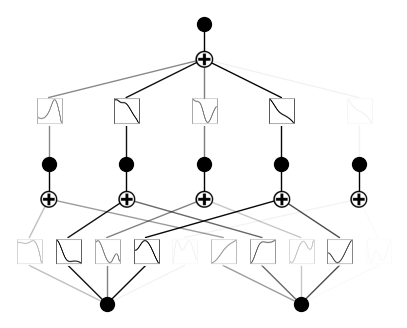

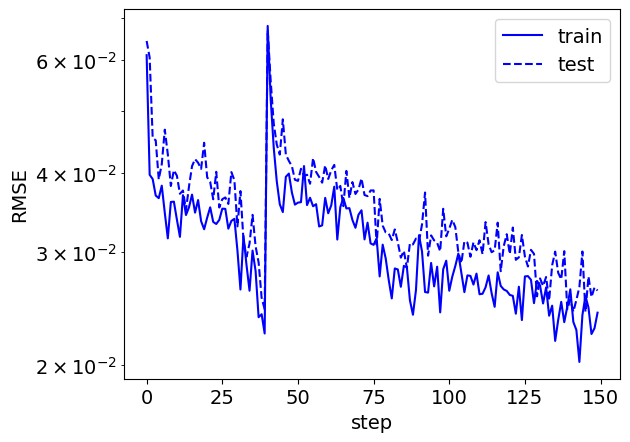

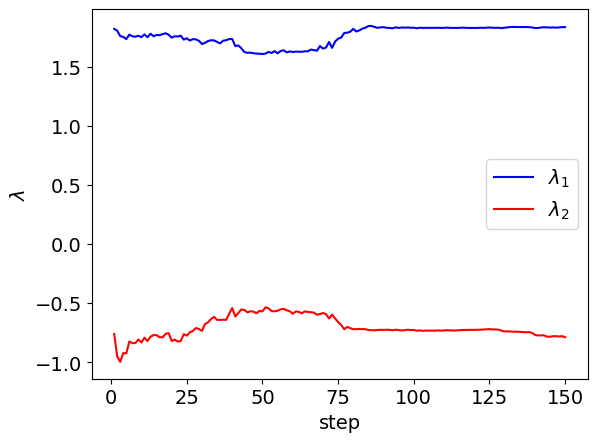

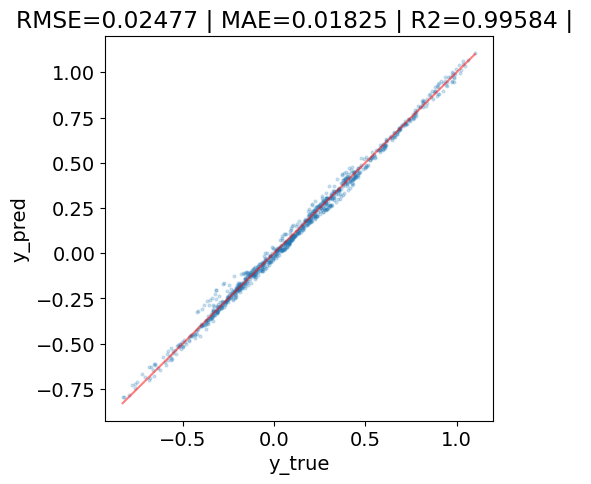

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.8371, -0.7889], requires_grad=True)


In [ ]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:17, 27.37it/s]                         


module of Input importance:


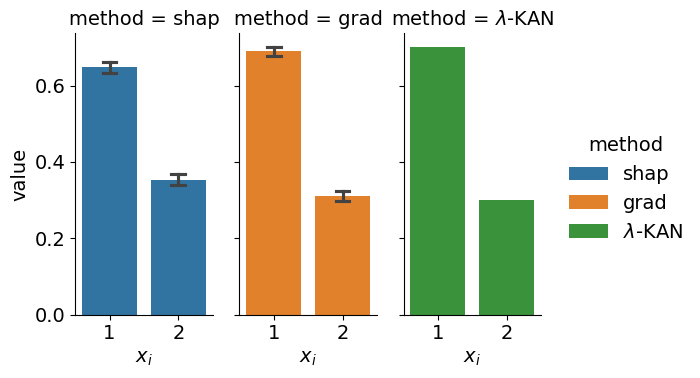

Input importance:


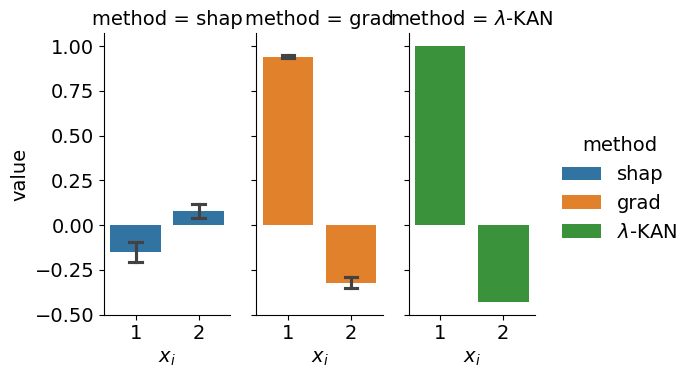

In [ ]:
importance_analyse_lmdKAN(model, dataset)

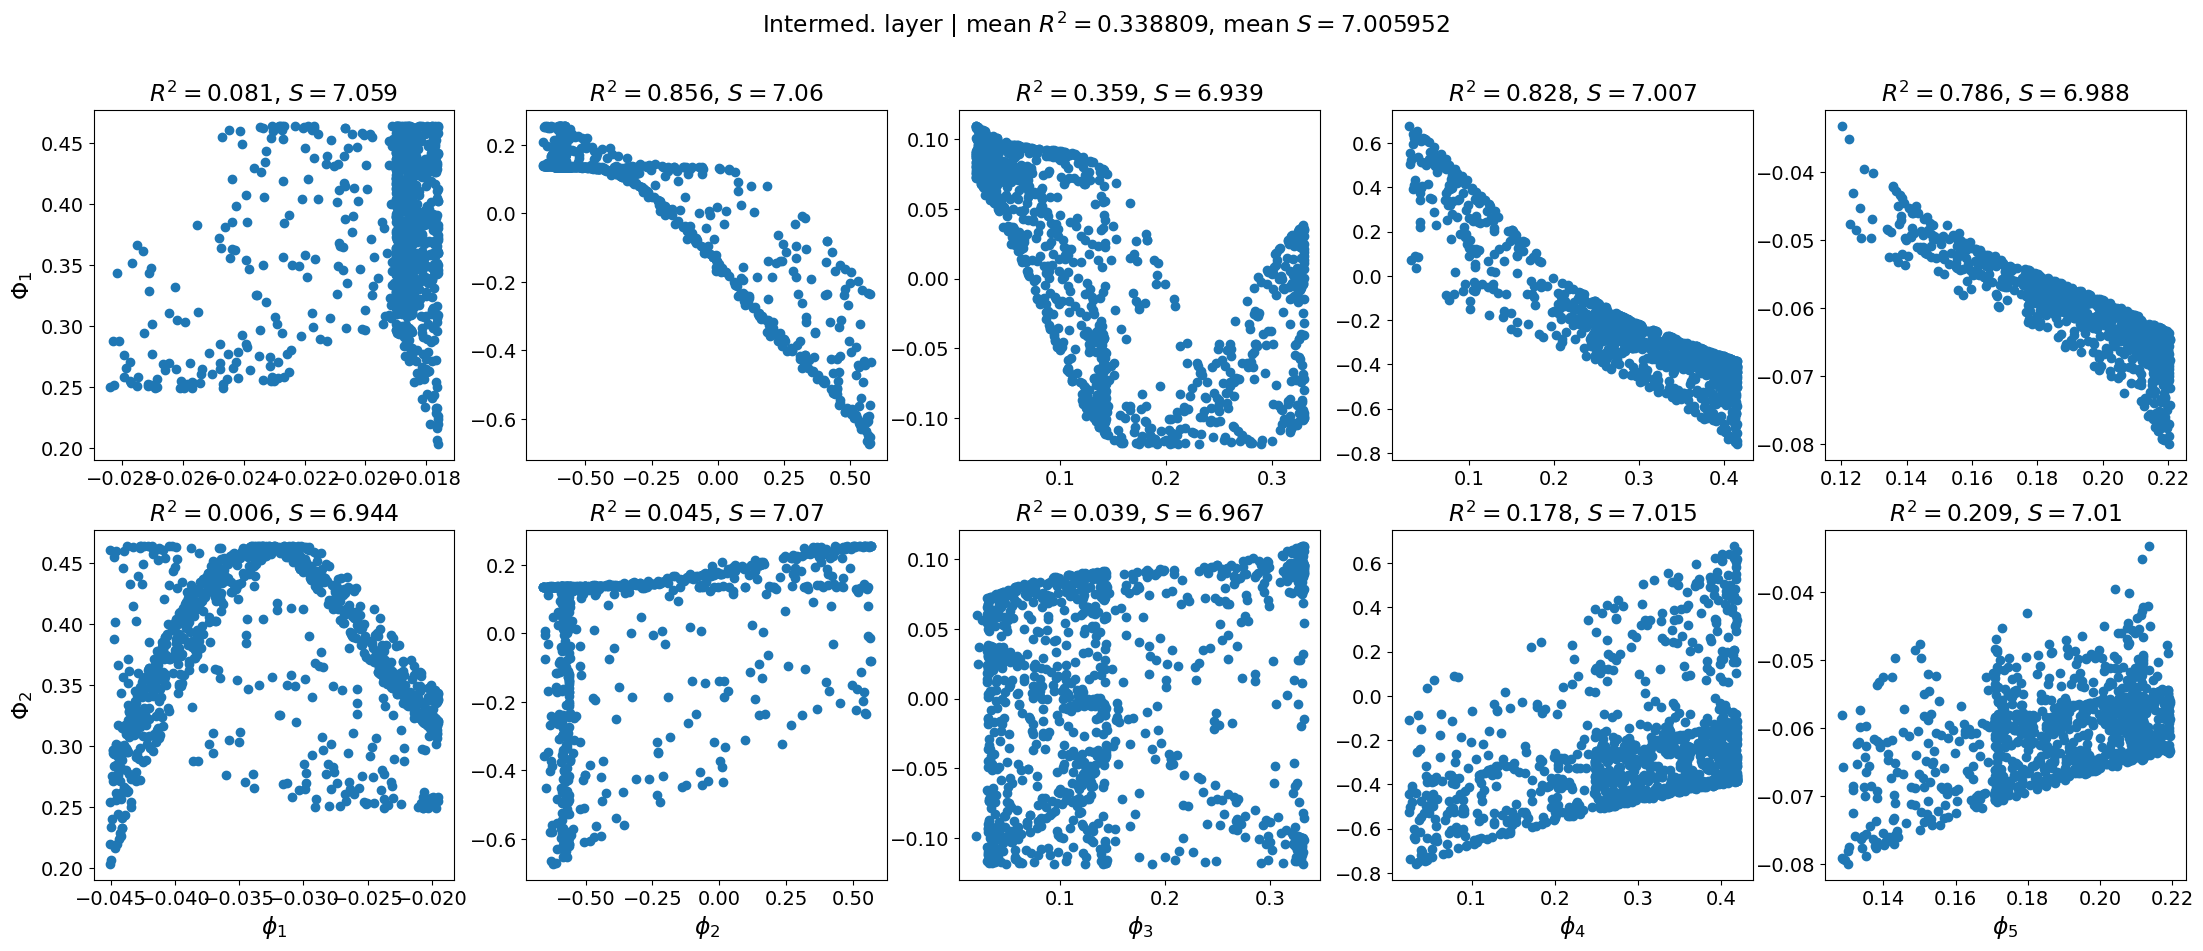

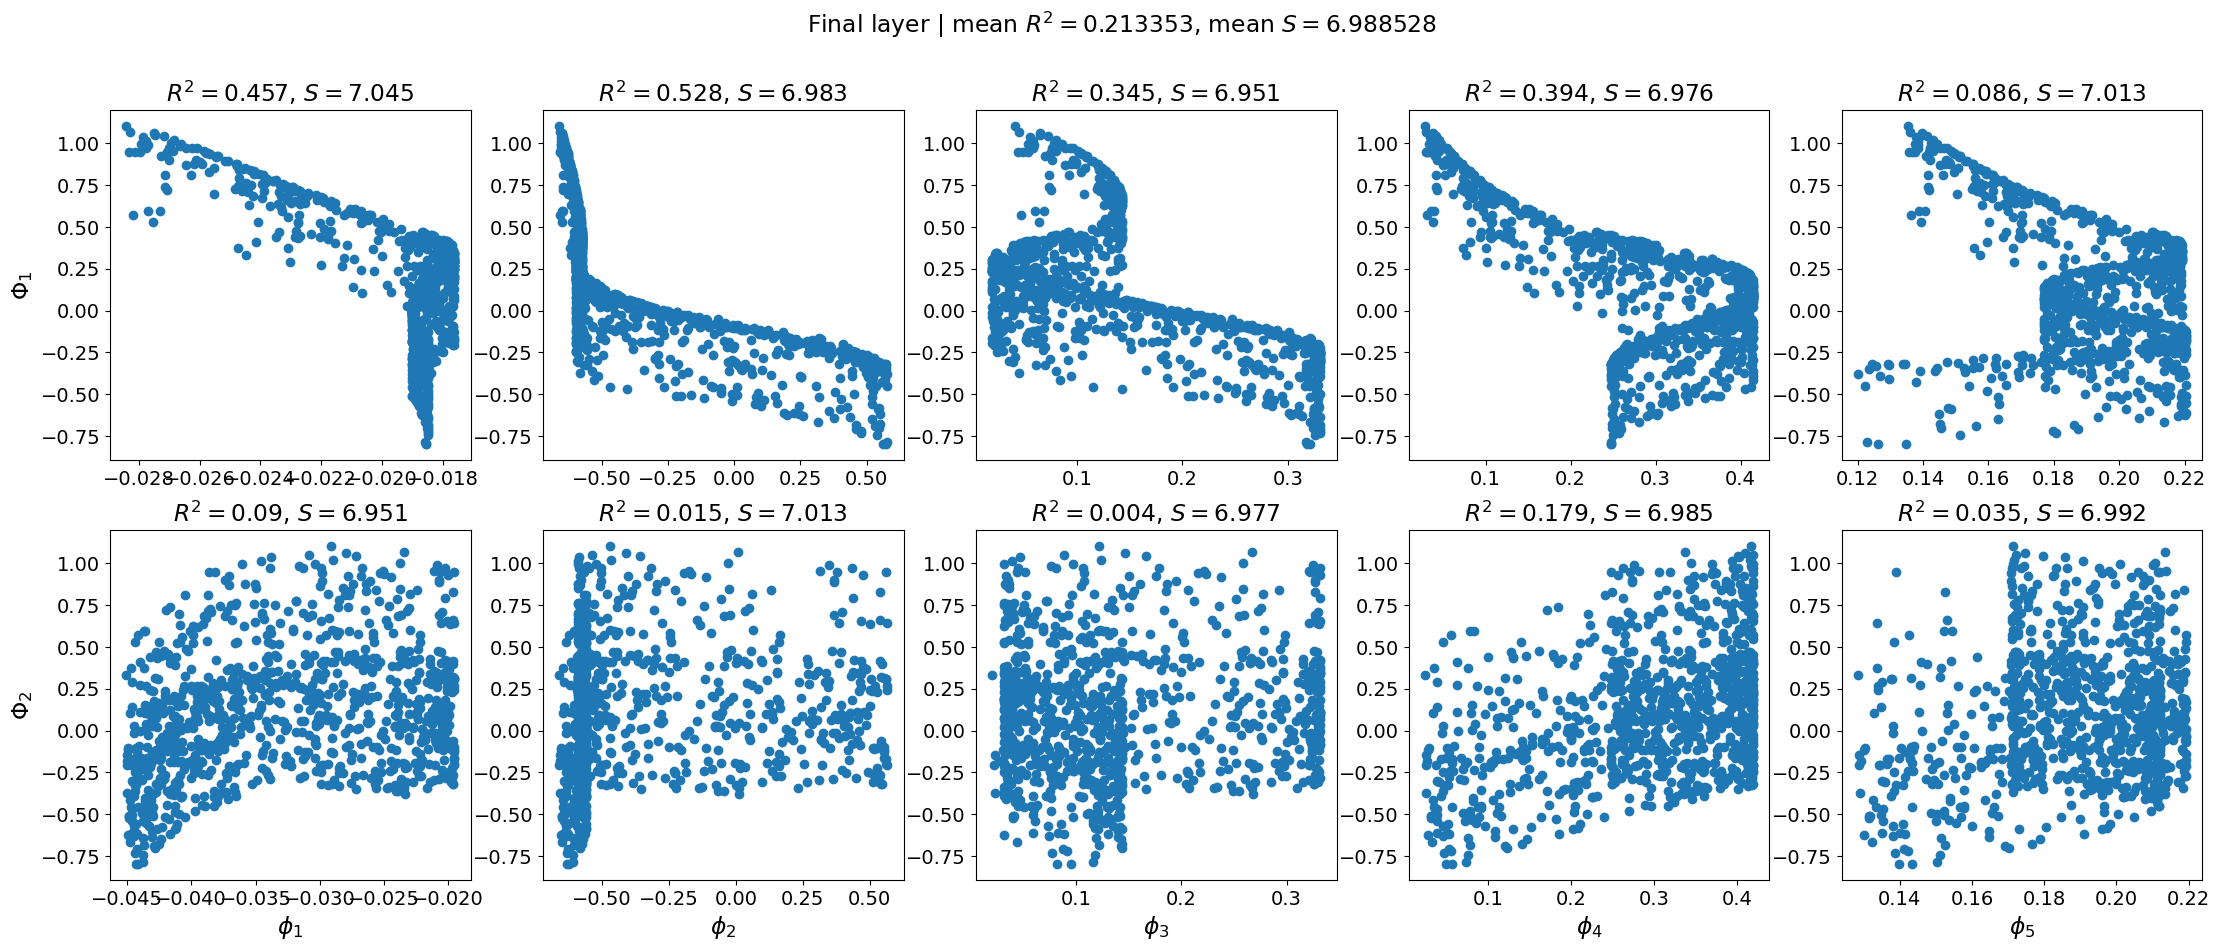

{'mean_r2': 0.21335328000131995, 'mean_matrix_entropy': 6.988528251647949}

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')